## 3. Autoencoders (AEs) en MNIST

a) Se cargan los datos y se dividen en 3 sets, uno de validación, pruebas y entrenamientos. De momento se aprovecha de normalizar los datos y reducir la dimensionalidad de estos.

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping 
from keras.models import load_model
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
import time

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]
print ('dimensiones entrada :')
print  ('x_train ', x_train.shape ,', y_train ' ,y_train.shape)
print  ('x_test ', x_test.shape ,', y_test ' ,y_test.shape)
print  ('x_val ', x_val.shape ,', y_val ' ,y_val.shape)

Using TensorFlow backend.


dimensiones entrada :
x_train  (55000, 784) , y_train  (55000,)
x_test  (10000, 784) , y_test  (10000,)
x_val  (5000, 784) , y_val  (5000,)


### 3.1 Reducción de dimensionalidad

a) Se entrenará un AE básico aplicando distintas dimensiones, pero antes de eso, probaremos dos AE, uno con una función de activación sigmoidal en el encoder, y otro con función de activación ReLU. Se utilizará un batch size de 32 con SGD(lr=1.0) y función de error binary_crossentropy, debido a que cada pixel es independiente, por lo que es válido hacer uso de esta función. Con respecto a esto último, si bien se podría haber utilizado mse, debido a que MNIST es "Error-tolerant", la generación de las nuevas imagenes, tendrían una percepción visual de difuminación, debido a que hace depender un pixel de otro pixel contiguo.

In [2]:

# modelo con activacion sigmoid
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))


compression_factor = float(x_train.shape[1]) / 32
print("Compression factor: %s" % compression_factor)

autoencoder.summary()

Compression factor: 24.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


f:\python3.6\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
f:\python3.6\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
f:\python3.6\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


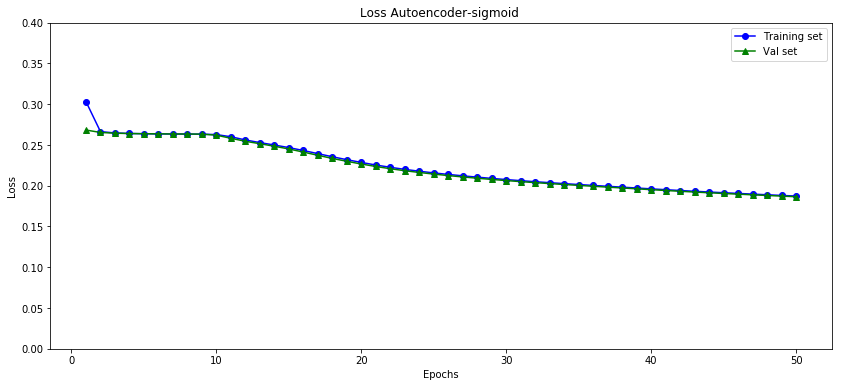

In [3]:

autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
results2 = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True,validation_data=(x_val, x_val),verbose=0)
results= results2.history

autoencoder.save('basic_autoencoder_768x32.h5')

loss_values1 = results['loss']
val_loss_values1 = results['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,6))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
axarr.set_title('Loss Autoencoder-sigmoid ')
axarr.set_ylim(0,0.4)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="upper right", fancybox= True)
plt.show()

f:\python3.6\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
f:\python3.6\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
f:\python3.6\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Compression factor: 24.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


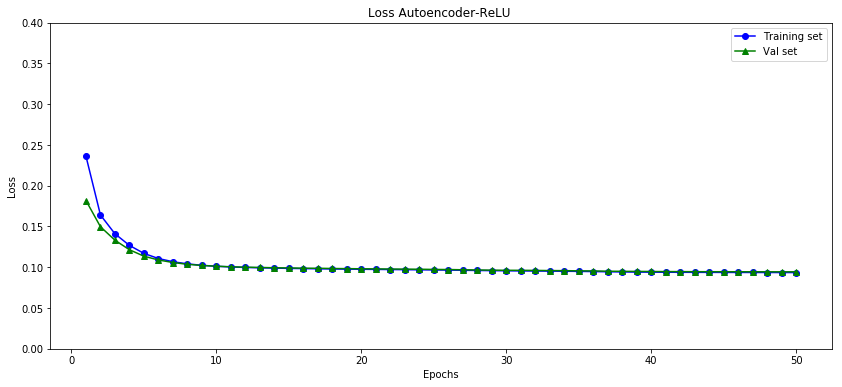

In [5]:
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

# modelo con activacion ReLU
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))


compression_factor = float(x_train.shape[1]) / 32
print("Compression factor: %s" % compression_factor)

autoencoder.summary()

autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
results2 = autoencoder.fit(x_train,x_train,callbacks=[monitor],epochs=50,batch_size=32,shuffle=True,validation_data=(x_val, x_val),verbose=0)
results= results2.history

autoencoder.save('basic_autoencoder_768x32_relu.h5')

loss_values1 = results['loss']
val_loss_values1 = results['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,6))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
axarr.set_title('Loss Autoencoder-ReLU ')
axarr.set_ylim(0,0.4)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="upper right", fancybox= True)
plt.show()

Gráficamente se puede observar que el comportamiento generado por la función de activación ReLU converge mas rapido y presenta un error menor que el obtenido con la función sigmoid.

In [6]:
#reduccion de dimensiones
dim = [2,4,8,16,32,64]
resultsdi= []
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

for di in dim:
    print("autoencoder para dimension: %s" % di)
    input_img = Input(shape=(784,))
    encoded = Dense(di, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(di,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

    autoencoder.compile(optimizer="adam", loss='binary_crossentropy')
    compression_factor = float(x_train.shape[1]) / di
    print("Compression factor: %s" % compression_factor)

    autoencoder.summary()
    results = autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,callbacks=[monitor],verbose=1, validation_data=(x_val, x_val))
    resultsdi.append(results)
    autoencoder.save('basic_autoencoder_784x'+str(di)+'relu.h5')



autoencoder para dimension: 2
Compression factor: 392.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 1s 25us/step - loss: 0.3988 - val_loss: 0.2841
Epoch 2/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.2759 - val_loss: 0.2689
Epoch 3/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.2628 - v

55000/55000 [==============================] - 1s 21us/step - loss: 0.1668 - val_loss: 0.1665
Epoch 32/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.1667 - val_loss: 0.1664
Epoch 33/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.1667 - val_loss: 0.1663
Epoch 34/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.1666 - val_loss: 0.1662
Epoch 35/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.1665 - val_loss: 0.1662
Epoch 36/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.1664 - val_loss: 0.1661
Epoch 37/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.1663 - val_loss: 0.1660
Epoch 38/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.1662 - val_loss: 0.1660
Epoch 39/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.1662 - val_loss: 0.1660
Epoch 40/50
55000/55000 [==============================] -

Epoch 12/50
55000/55000 [==============================] - 1s 19us/step - loss: 0.0764 - val_loss: 0.0769
Epoch 13/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.0758 - val_loss: 0.0763
Epoch 14/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.0753 - val_loss: 0.0759
Epoch 15/50
55000/55000 [==============================] - 1s 19us/step - loss: 0.0749 - val_loss: 0.0756
Epoch 16/50
55000/55000 [==============================] - 1s 20us/step - loss: 0.0746 - val_loss: 0.0753
Epoch 17/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.0743 - val_loss: 0.0751
Epoch 18/50
55000/55000 [==============================] - 1s 21us/step - loss: 0.0741 - val_loss: 0.0749
Epoch 19/50
55000/55000 [==============================] - 1s 19us/step - loss: 0.0740 - val_loss: 0.0747
Epoch 20/50
55000/55000 [==============================] - 1s 19us/step - loss: 0.0738 - val_loss: 0.0746
Epoch 21/50
55000/55000 [=====================

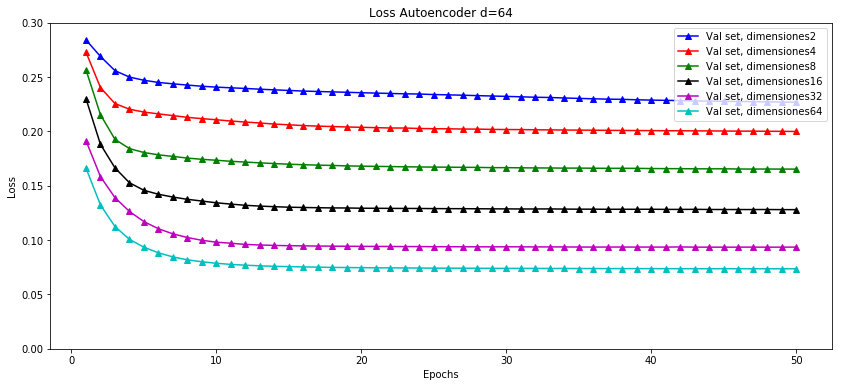

In [7]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,figsize=(14,6)) 
colores = ['b','r','g','k','m','c']

for histori,col,d in zip(resultsdi,colores,dim): #para cada dimension

    hist = histori.history
    #loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(val_loss_values1) + 1)

    #axarr.plot(epochs1, loss_values1, col+'o-', label = "Training set, dimensiones"+str(d))
    axarr.plot(epochs1, val_loss_values1, col+'^-',label = "Val set, dimensiones"+str(d))
    axarr.set_title('Loss Autoencoder d='+str(d))
    axarr.set_ylim(0,0.3)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')

    axarr.legend(loc="upper right", fancybox= True)
plt.show()

Al probar con las distintas dimensiones, podemos ver que en todos los casos existe un comportamiento similar, pero hay una gran diferencia en los valores obtenidos, dado a que se podría aseverar de que la red no aprende más. Esto queda dismitificado, debido a que no hubo intervención alguna del early stopping, pero eso no cambia el hecho de que una vez cumplidos los 10 epochs de entrenamiento, no existe diferencia significante en el entrenamiento. Pese a esto, el gráfico nos da a entender que a mayor cantidad de dimensiones, menor pérdida durante el entrenamiento.

b) En este punto, se presentarán los resultados obtenidos por cada red.

#### ReLU

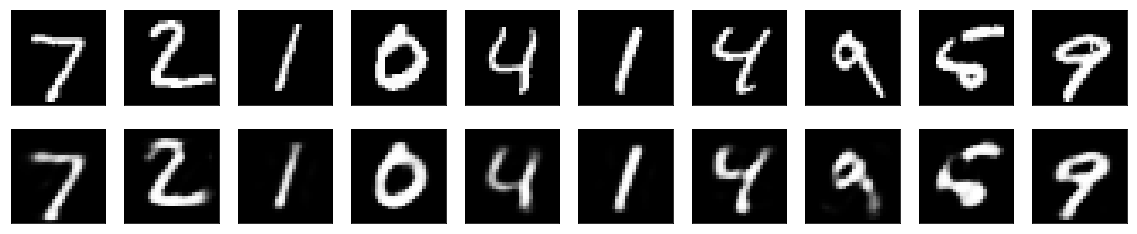

In [8]:

autoencoder = load_model('basic_autoencoder_768x32_relu.h5')
#load other stuff ...

input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))  
decoded_shape = Input(shape=(32,))   
decoder_layer = autoencoder.layers[-1] 
decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Sigmoid

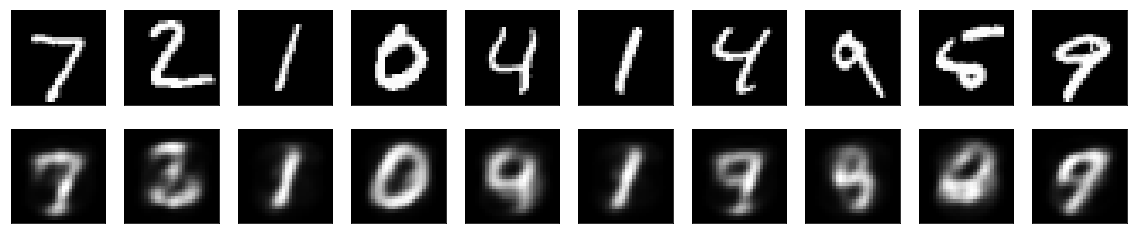

In [9]:

autoencoder = load_model('basic_autoencoder_768x32.h5')


input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))

decoded_shape = Input(shape=(32,))   
decoder_layer = autoencoder.layers[-1] 
decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))


encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos apreciar claramente que el autoencoder, cuyo decoder utiliza la función de activación ReLU, presenta mejores resultados, con menos ruido y mas precisos a diferencia de la red ejecutada con sigmoid, donde aparte de ser poco legible, presenta errores de interpretación, como lo son los pares 9-4 y 5-0. A continuación se darán a conocer los otros resultados obtenidos. Recordar que estos valores fueron obtenidos con batch size de 256, adam y binary-crossentropy.

dimension :  2


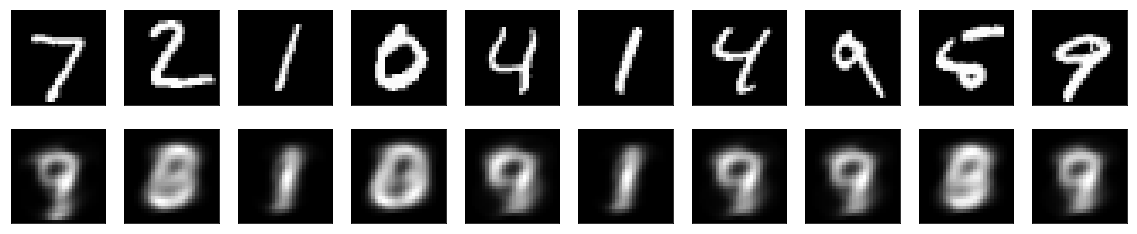

dimension :  4


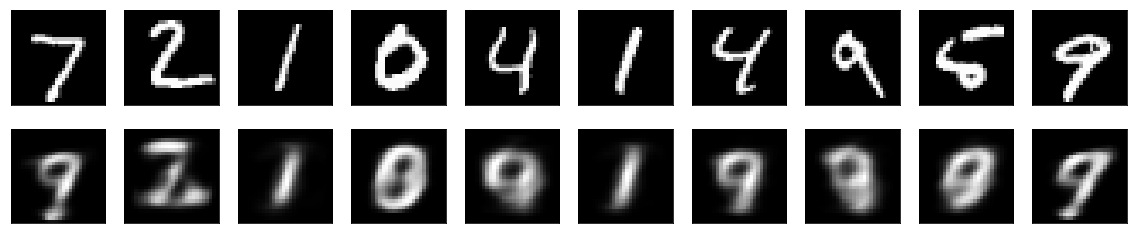

dimension :  8


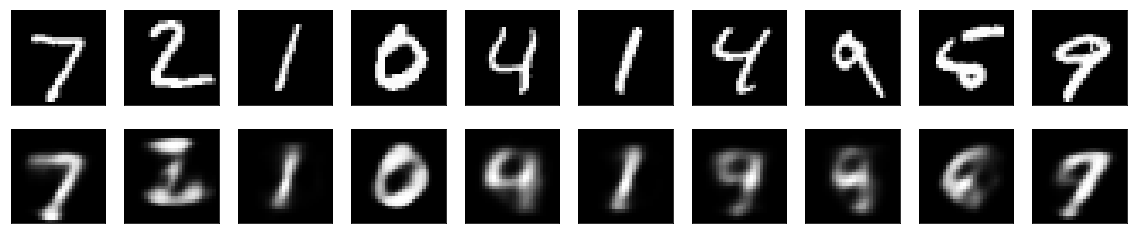

dimension :  16


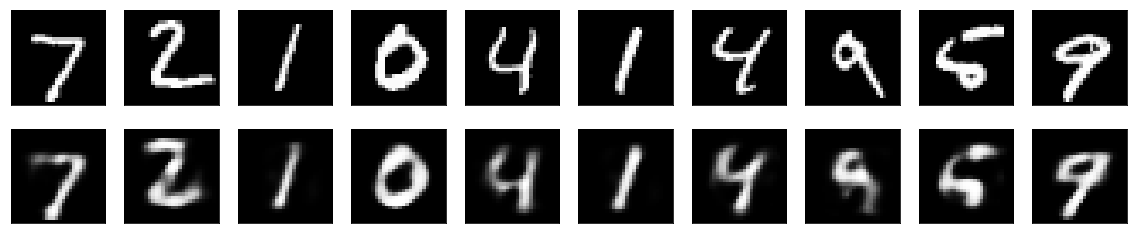

dimension :  32


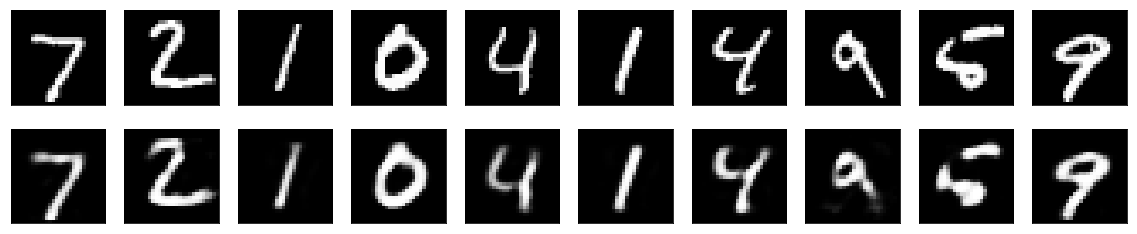

dimension :  64


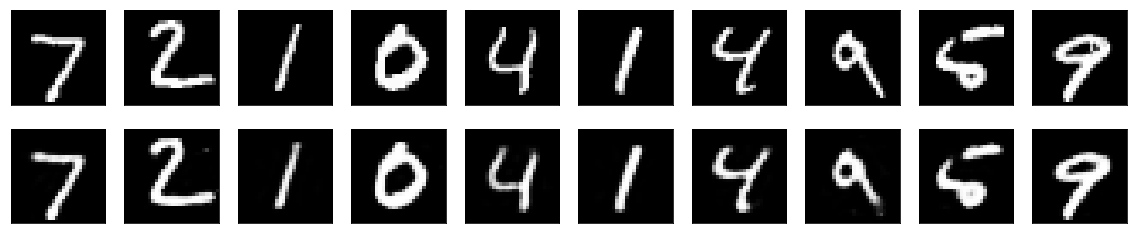

In [10]:

for dimensiones in dim :
    print ('dimension : ',dimensiones)
    hdf5 = 'basic_autoencoder_784x'+ str(dimensiones)+'relu.h5'
    autoencoder = load_model(hdf5)
    
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
   
    decoded_shape = Input(shape=(dimensiones,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

    
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    
    
    
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Si analizamos estas ultimas comparaciones, podemos deducir que aumentando las dimensiones obtenemos mejores resultados al momento de realizar las predicciones, respaldando lo anteriormente atribuido y teorizado mediante los resultados del punto anterior, donde a medida que la dimensión aumenta, la predicción es mas precisa y en algunos casos hasta mejora la calidad. Al mismo tiempo, se puede apreciar visualmente la diferencia entre las brechas generadas por los gráficos, donde en cada ejemplo se observa una notoria mejora entre una predicción y otra. Esta disminuye ya cuando se compara lo obtenido entre el modelo de dimensión 32 con el modelo de dimensión 64.

c) En esta parte se verificará la calidad de los modelos, comparando las predicciones obtenidas por el modelo con las predicciones ejecutadas por PCA.

In [11]:

for dimensiones in dim :
    print ('dimension : ',dimensiones)
    hdf5 = 'basic_autoencoder_784x'+ str(dimensiones)+'relu.h5'
    autoencoder = load_model(hdf5)
    
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
   
    decoded_shape = Input(shape=(dimensiones,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))
    
    pca = PCA(n_components=dimensiones)
     
    #PCA
    start = time.clock()
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    end = time.clock()
    print("Time PCA fit: %.5f " % (end-start))
    
    #AUTOENCODER
    start = time.clock()
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    end = time.clock()
    print("Time AE fit: %.5f \n" % (end-start))
    
    #CLASIFICATION
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print ('Classification Accuracy PCA %.3f' % clf.score(pca_test,y_test))
    end = time.clock()
    print("Time clf PCA: %.5f " % (end-start))
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ('Classification Accuracy %.3f' % clf.score(encoded_test,y_test))
    end = time.clock()
    print("Time clf encoded: %.5f \n\n" % (end-start))

dimension :  2
Time PCA fit: 1.59939 
Time AE fit: 1.62154 

Classification Accuracy PCA 0.438
Time clf PCA: 0.09721 
Classification Accuracy 0.386
Time clf encoded: 0.09837 


dimension :  4
Time PCA fit: 1.83954 
Time AE fit: 1.60542 

Classification Accuracy PCA 0.642
Time clf PCA: 0.19856 
Classification Accuracy 0.650
Time clf encoded: 0.19376 


dimension :  8
Time PCA fit: 1.39881 
Time AE fit: 1.59217 

Classification Accuracy PCA 0.903
Time clf PCA: 0.99269 
Classification Accuracy 0.891
Time clf encoded: 0.82793 


dimension :  16
Time PCA fit: 1.67119 
Time AE fit: 1.76099 

Classification Accuracy PCA 0.961
Time clf PCA: 5.88261 
Classification Accuracy 0.951
Time clf encoded: 5.62249 


dimension :  32
Time PCA fit: 1.87975 
Time AE fit: 1.67257 

Classification Accuracy PCA 0.974
Time clf PCA: 21.43627 
Classification Accuracy 0.963
Time clf encoded: 31.11489 


dimension :  64
Time PCA fit: 2.32619 
Time AE fit: 1.80508 

Classification Accuracy PCA 0.973
Time clf PCA: 5

De los resultados, podemos afirmar que la precisión utilizando PCA es mayor que la de nuestros modelos, también se puede fundamentar que el tiempo utilizado por PCA es significativamente menor en dimensiones mas grandes. Esto ultimo es importante, ya que para ambos metodos una mayor dimensión implica una mejor predicción, por consiguiente, se concluye que una predicción mediante la utilización de PCA es mas eficiente que la predicción entregada por el autoencoder.

d) A continuación se repetirá lo realizado hasta ahora, pero utilizando un *deep autonencoder*, con la idea y el objetivo de superar la utilización de PCA

autoencoder para dimension: 2
Compression factor: 392.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 258       
_________________________________________________________________
dense_21 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_22 (Dense)    

f:\python3.6\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
f:\python3.6\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 55us/step - loss: 0.2707 - val_loss: 0.2490
Epoch 2/50
55000/55000 [==============================] - 2s 35us/step - loss: 0.2414 - val_loss: 0.2354
Epoch 3/50
55000/55000 [==============================] - 2s 35us/step - loss: 0.2314 - val_loss: 0.2207
Epoch 4/50
55000/55000 [==============================] - 2s 35us/step - loss: 0.2075 - val_loss: 0.1993
Epoch 5/50
55000/55000 [==============================] - 2s 35us/step - loss: 0.1959 - val_loss: 0.1915
Epoch 6/50
55000/55000 [==============================] - 2s 36us/step - loss: 0.1905 - val_loss: 0.1874
Epoch 7/50
55000/55000 [==============================] - 2s 36us/step - loss: 0.1874 - val_loss: 0.1855
Epoch 8/50
55000/55000 [==============================] - 2s 36us/step - loss: 0.1848 - val_loss: 0.1837
Epoch 9/50
55000/55000 [==============================] - 2s 36us/step - loss: 0.1837 - val_loss: 0.1820
Epoch 

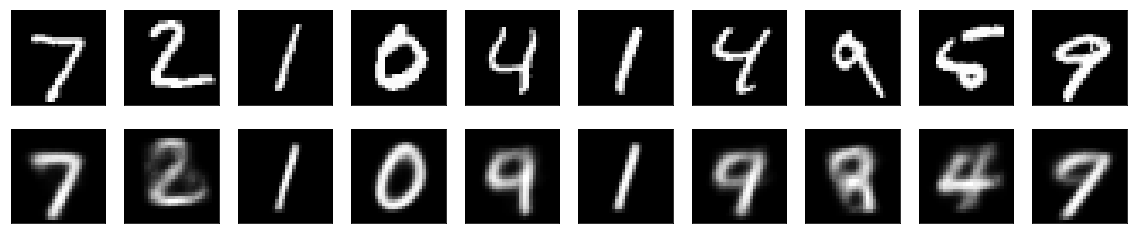

autoencoder para dimension: 4
Compression factor: 196.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 516       
_________________________________________________________________
dense_29 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_30 (Dense)    

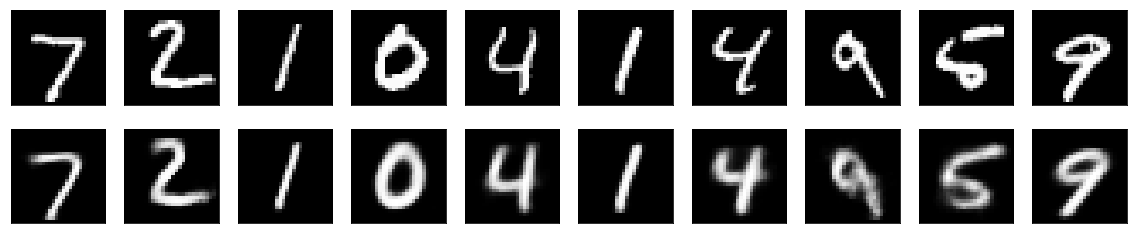

autoencoder para dimension: 8
Compression factor: 98.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_37 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_38 (Dense)     

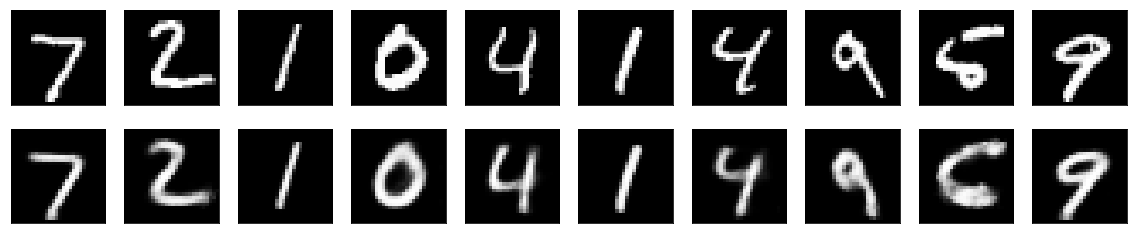

autoencoder para dimension: 16
Compression factor: 49.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_44 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_46 (Dense)    

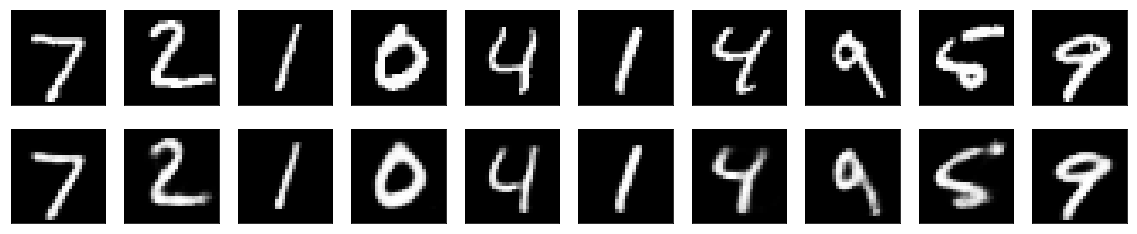

autoencoder para dimension: 32
Compression factor: 24.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_52 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_53 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_54 (Dense)    

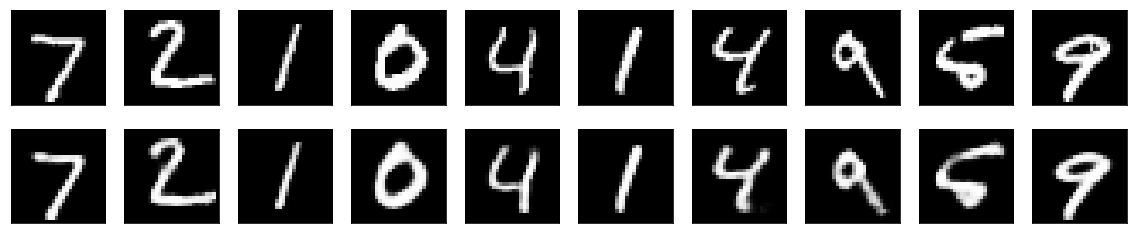

autoencoder para dimension: 64
Compression factor: 12.25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_59 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_61 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_62 (Dense)   

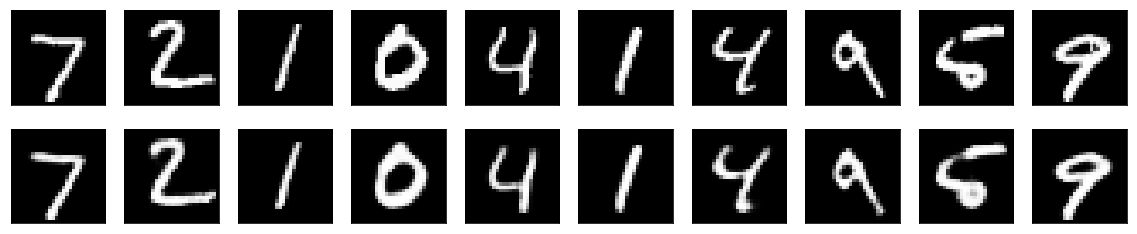

In [12]:
#reduccion de dimensiones
dim = [2,4,8,16,32,64]
resultsdi= []
encodedim = []
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

for di in dim:
    print("autoencoder para dimension: %s" % di)
    input_img = Input(shape=(784,))  
    encoded1 = Dense(512, activation='relu')(input_img)
    encoded2 = Dense(256, activation='relu')(encoded1)
    encoded3 = Dense(128, activation='relu')(encoded2)
    encoded4 = Dense(di, activation='relu')(encoded3)
    decoded4 = Dense(128, activation='relu')(encoded4)
    decoded3 = Dense(256, activation='relu')(decoded4)
    decoded2 = Dense(512, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded4)

    
    autoencoder.compile(optimizer="adam", loss='binary_crossentropy')
    compression_factor = float(x_train.shape[1]) / di
    print("Compression factor: %s" % compression_factor)
    autoencoder.summary()
    results = autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,callbacks=[monitor],verbose=1, validation_data=(x_val, x_val))
    resultsdi.append(results)
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    encodedim.append([encoded_train,encoded_test])
    decoded_imgs = autoencoder.predict(x_test)

    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    autoencoder.save('deep_autoencoder_784x'+str(di)+'relu.h5')
    encoder.save('encoder_save_deep_autoencoder_784x'+str(di)+'relu.h5', overwrite=True)

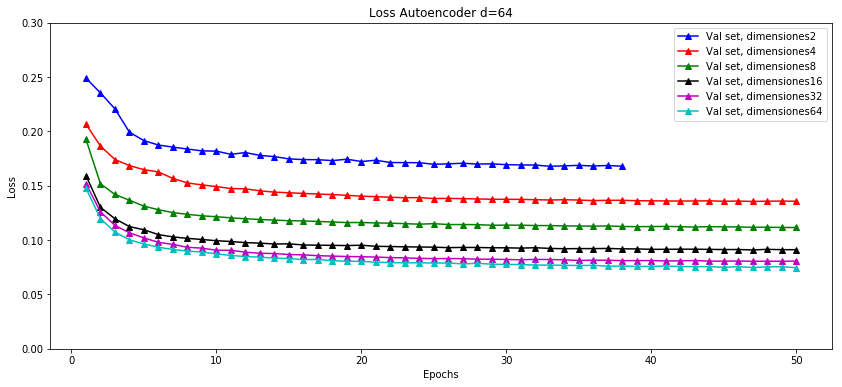

In [13]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,figsize=(14,6)) 
colores = ['b','r','g','k','m','c']

for histori,col,d in zip(resultsdi,colores,dim): #para cada dimension

    hist = histori.history
    #loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(val_loss_values1) + 1)

    #axarr.plot(epochs1, loss_values1, col+'o-', label = "Training set, dimensiones"+str(d))
    axarr.plot(epochs1, val_loss_values1, col+'^-',label = "Val set, dimensiones"+str(d))
    axarr.set_title('Loss Autoencoder d='+str(d))
    axarr.set_ylim(0,0.3)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')

    axarr.legend(loc="upper right", fancybox= True)
plt.show()

In [14]:
contador = 0
for dimensiones in dim :
    print ('dimension : ',dimensiones)
    pca = PCA(n_components=dimensiones)
     
    #PCA

    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    
    hdf5 = 'encoder_save_deep_autoencoder_784x'+str(dimensiones)+'relu.h5'
    encoder = load_model(hdf5)
    
    #AUTOENCODER
    encoder_train1 = encoder.predict(x_train)
    encoder_test1 = encoder.predict(x_test)
    
    #CLASIFICATION
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print ('Classification Accuracy PCA %.3f' % clf.score(pca_test,y_test))
    end = time.clock()
    print("Time clf PCA: %.5f " % (end-start))
    
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(encoder_train1, y_train)
    print ('Classification Accuracy load_encoder %.3f' % clf.score(encoder_test1,y_test))
    end = time.clock()
    print("Time clf encoded: %.5f \n\n" % (end-start))
    


dimension :  2


f:\python3.6\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.438
Time clf PCA: 0.10257 
Classification Accuracy load_encoder 0.797
Time clf encoded: 0.10055 


dimension :  4
Classification Accuracy PCA 0.642
Time clf PCA: 0.19230 
Classification Accuracy load_encoder 0.932
Time clf encoded: 0.18312 


dimension :  8
Classification Accuracy PCA 0.903
Time clf PCA: 0.98534 
Classification Accuracy load_encoder 0.955
Time clf encoded: 0.62516 


dimension :  16
Classification Accuracy PCA 0.961
Time clf PCA: 7.42864 
Classification Accuracy load_encoder 0.972
Time clf encoded: 4.81210 


dimension :  32
Classification Accuracy PCA 0.974
Time clf PCA: 21.42028 
Classification Accuracy load_encoder 0.977
Time clf encoded: 25.14649 


dimension :  64
Classification Accuracy PCA 0.973
Time clf PCA: 54.14445 
Classification Accuracy load_encoder 0.973
Time clf encoded: 79.21415 




En este caso se utilizó un *deep AE* con 4 capas de profundidad aplicando las dimensiones usadas en los puntos anteriores. En un principio, se observa que los loss son menores a medida que aumenta la dimensión, eso si, parece alcanzar su límite y disminuir radicalmente su progreso pasada la dimensión 32. También se observa algo de overfitting  en las dimensiones 2, 4 y 8.

Mientras tanto, en la comparación con PCA se observa una gran superioridad en nuestro AE a nivel de precisión desde el inicio, donde un 80,8% de precisión es obtenida por el autoencoder con dimension 2, por otro lado, los tiempos también son menores, hasta la dimensión 32 que es donde el tiempo que toma el AE supera al del PCA, además, para ambos clasificadores, se aprecia el alcance de un máximo en la precisión, la cual no supera el 97,4%.

Si bien se pudo demostrar que un autencoder profundo mejora la compresión obtenida, debido a la precisión entregada.

autoencoder para dimension: 2
Compression factor: 392.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 514       
_________________________________________________________________
dense_68 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_69 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_70 (Dense)    

f:\python3.6\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()
f:\python3.6\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 3s 55us/step - loss: 0.2738 - val_loss: 0.2493
Epoch 2/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.2287 - val_loss: 0.2138
Epoch 3/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.2087 - val_loss: 0.2035
Epoch 4/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.2014 - val_loss: 0.1983
Epoch 5/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.1972 - val_loss: 0.1946
Epoch 6/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.1925 - val_loss: 0.1885
Epoch 7/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.1879 - val_loss: 0.1849
Epoch 8/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.1852 - val_loss: 0.1828
Epoch 9/50
55000/55000 [==============================] - 2s 33us/step - loss: 0.1834 - val_loss: 0.1814
Epoch 

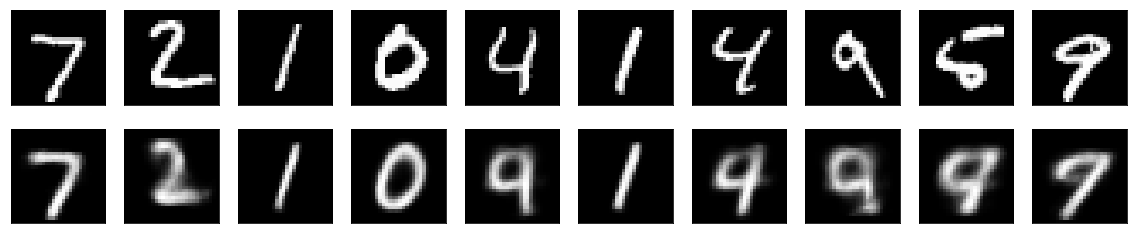

autoencoder para dimension: 4
Compression factor: 196.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 1028      
_________________________________________________________________
dense_74 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_75 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_76 (Dense)    

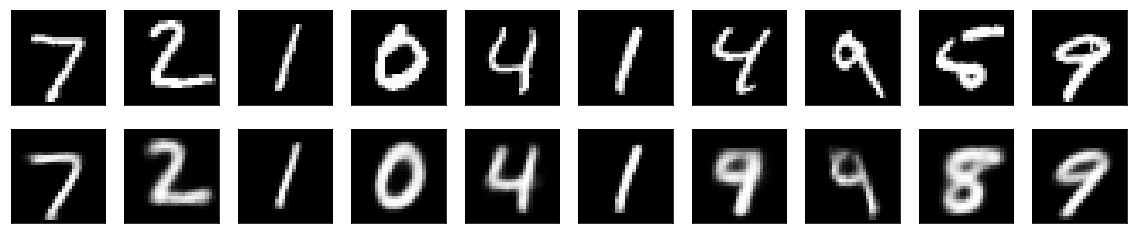

autoencoder para dimension: 8
Compression factor: 98.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_79 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_80 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_81 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_82 (Dense)     

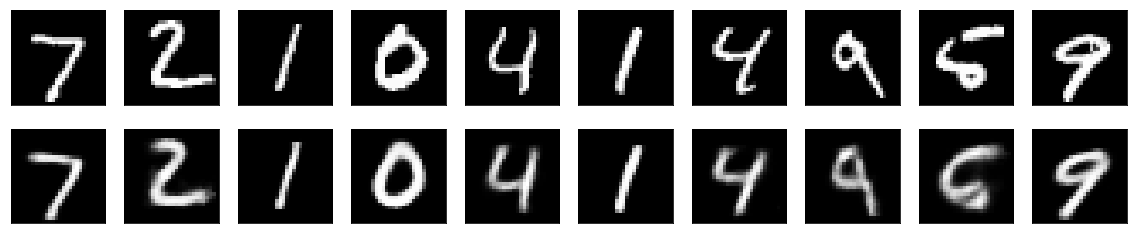

autoencoder para dimension: 16
Compression factor: 49.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_84 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_85 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_86 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_87 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_88 (Dense)    

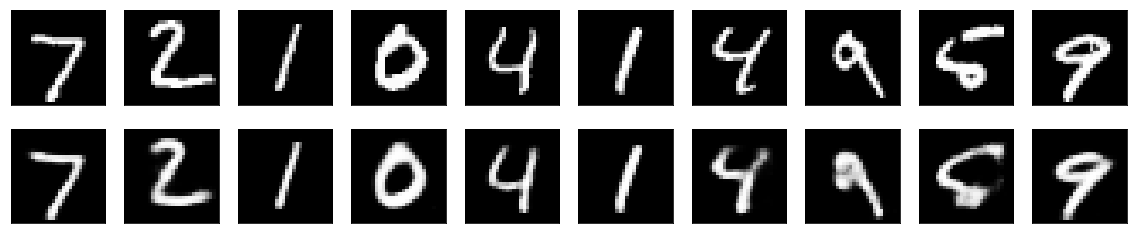

autoencoder para dimension: 32
Compression factor: 24.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_90 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_91 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_92 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_93 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_94 (Dense)    

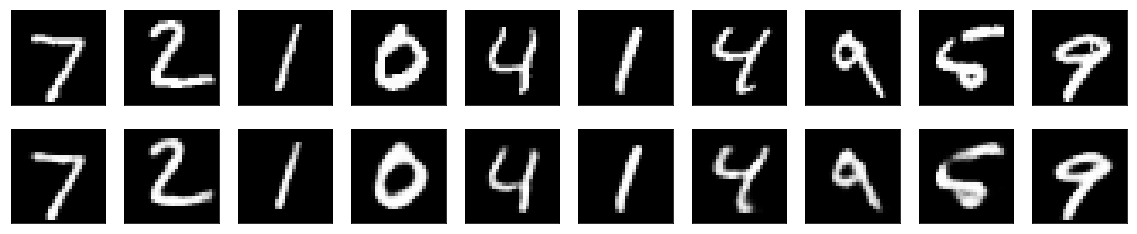

autoencoder para dimension: 64
Compression factor: 12.25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_96 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_97 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_98 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_99 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_100 (Dense)  

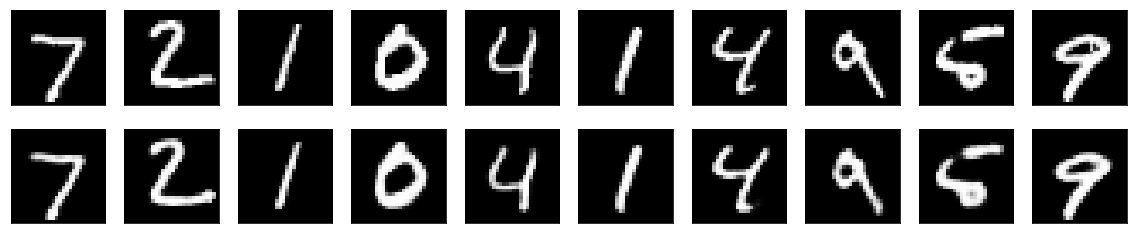

In [15]:
#reduccion de dimensiones
dim = [2,4,8,16,32,64]
resultsdi= []
encodedim = []
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

for di in dim:
    print("autoencoder para dimension: %s" % di)
    input_img = Input(shape=(784,))  
    encoded1 = Dense(512, activation='relu')(input_img)
    encoded2 = Dense(256, activation='relu')(encoded1)
    encoded4 = Dense(di, activation='relu')(encoded2)
    decoded3 = Dense(256, activation='relu')(encoded4)
    decoded2 = Dense(512, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded4)

    
    autoencoder.compile(optimizer="adam", loss='binary_crossentropy')
    compression_factor = float(x_train.shape[1]) / di
    print("Compression factor: %s" % compression_factor)
    autoencoder.summary()
    results = autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,callbacks=[monitor],verbose=1, validation_data=(x_val, x_val))
    resultsdi.append(results)
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    encodedim.append([encoded_train,encoded_test])
    decoded_imgs = autoencoder.predict(x_test)

    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    autoencoder.save('deep_autoencoder_784x'+str(di)+'relu_L_3.h5')
    encoder.save('encoder_save_deep_autoencoder_784x'+str(di)+'relu_L_3.h5', overwrite=True)

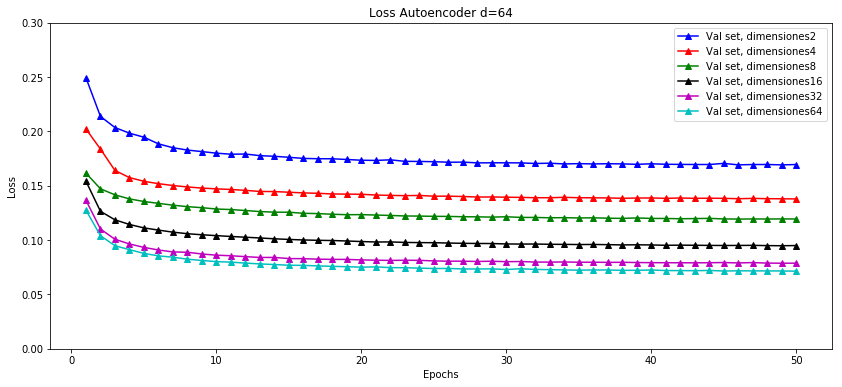

In [16]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,figsize=(14,6)) 
colores = ['b','r','g','k','m','c']

for histori,col,d in zip(resultsdi,colores,dim): #para cada dimension

    hist = histori.history
    #loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(val_loss_values1) + 1)

    #axarr.plot(epochs1, loss_values1, col+'o-', label = "Training set, dimensiones"+str(d))
    axarr.plot(epochs1, val_loss_values1, col+'^-',label = "Val set, dimensiones"+str(d))
    axarr.set_title('Loss Autoencoder d='+str(d))
    axarr.set_ylim(0,0.3)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')

    axarr.legend(loc="upper right", fancybox= True)
plt.show()

In [17]:
contador = 0
for dimensiones in dim :
    print ('dimension : ',dimensiones)
    pca = PCA(n_components=dimensiones)
     
    #PCA

    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)

    
    hdf5 = 'encoder_save_deep_autoencoder_784x'+str(dimensiones)+'relu_L_3.h5'
    encoder = load_model(hdf5)
    
    #AUTOENCODER
    encoder_train1 = encoder.predict(x_train)
    encoder_test1 = encoder.predict(x_test)
    
    #CLASIFICATION
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print ('Classification Accuracy PCA %.3f' % clf.score(pca_test,y_test))
    end = time.clock()
    print("Time clf PCA: %.5f " % (end-start))
    
    
    start = time.clock()
    clf = KNeighborsClassifier(10)
    clf.fit(encoder_train1, y_train)
    print ('Classification Accuracy load_encoder %.3f' % clf.score(encoder_test1,y_test))
    end = time.clock()
    print("Time clf encoded: %.5f \n\n" % (end-start))

dimension :  2


f:\python3.6\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy PCA 0.438
Time clf PCA: 0.09527 
Classification Accuracy load_encoder 0.779
Time clf encoded: 0.09409 


dimension :  4
Classification Accuracy PCA 0.642
Time clf PCA: 0.19336 
Classification Accuracy load_encoder 0.912
Time clf encoded: 0.18060 


dimension :  8
Classification Accuracy PCA 0.903
Time clf PCA: 0.97788 
Classification Accuracy load_encoder 0.951
Time clf encoded: 0.52719 


dimension :  16
Classification Accuracy PCA 0.961
Time clf PCA: 5.98170 
Classification Accuracy load_encoder 0.969
Time clf encoded: 4.68525 


dimension :  32
Classification Accuracy PCA 0.974
Time clf PCA: 21.56311 
Classification Accuracy load_encoder 0.973
Time clf encoded: 27.90186 


dimension :  64
Classification Accuracy PCA 0.973
Time clf PCA: 54.14535 
Classification Accuracy load_encoder 0.972
Time clf encoded: 81.64569 




e) A continuación, se compararán cualitativamente las representaciones entregadas por TSNE con las de PCA.

f:\python3.6\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


prefit
postfit
tiempo: 112.354


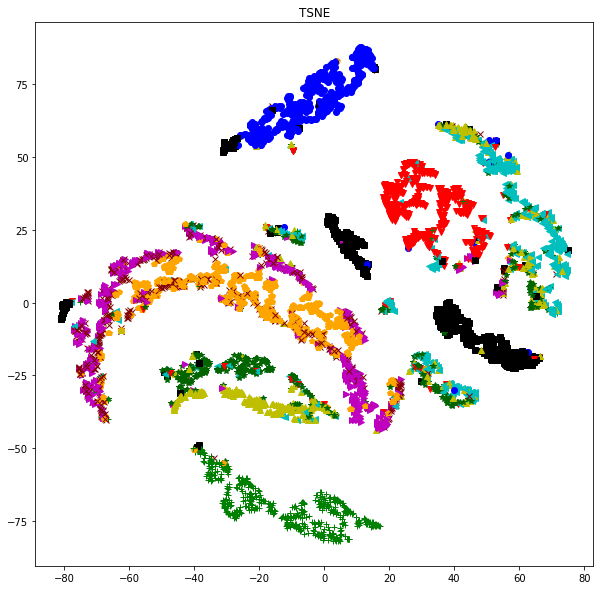

prefit
postfit
tiempo: 115.258


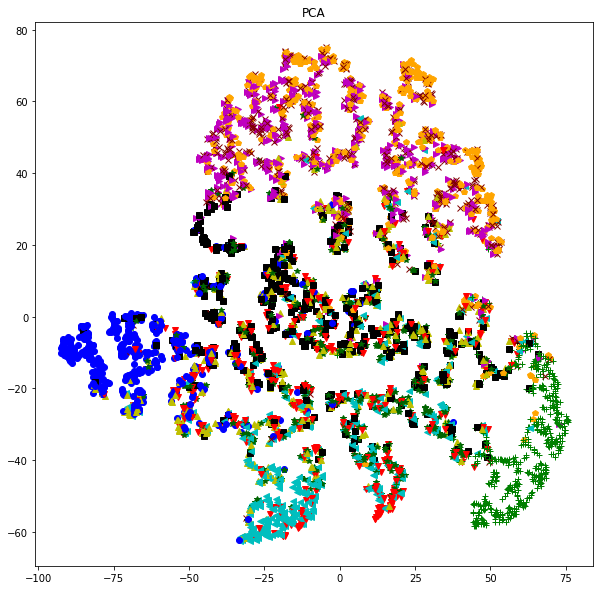

In [12]:

nplot=5000 #warning: mind your memory!
hdf5 = 'encoder_save_deep_autoencoder_784x2relu.h5'
encoder = load_model(hdf5)
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
print('prefit')
start = time.clock()
encoded_train = model.fit_transform(encoded_train)
end = time.clock()
print('postfit\ntiempo: %.3f' % (end-start))
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.title('Deep_autoencoder')
plt.show()

pca = PCA(n_components=2)
nplot=5000
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
model = TSNE(n_components=2, random_state=0)
print('prefit')
start = time.clock()
encoded_train = model.fit_transform(encoded_train)
end = time.clock()
print('postfit\ntiempo: %.3f' % (end-start))
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.title('PCA')
plt.show()

Se puede apreciar mediante los datos expuestos, que TSNE presenta un mejor rendimiento que PCA, esto es debido a la "polarización" que utiliza en su algoritmo, pese a esto, aún existen algunas clasificaciones fuera de su cluster, esto nos indica que la utilización de 2 componentes no es suficiente para clasificar cada patron. Aunque ambos algoritmos no sean perfectos, TSNE demostró poder clasificar la mayoria de los pixeles, 
### STAND BY

f) En este punto se aplicarán capas convolucionales para el autoencoder, para poder verificar si esta práctica es mejor a las realizadas anteriormente. Las matrices seran de dimensiones 28x28x1 y se reducirán a 4,4,4 (64 dimensiones).

In [21]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping 
from keras.models import load_model
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
import time

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]
print ('dimensiones entrada :')
print  ('x_train ', x_train.shape ,', y_train ' ,y_train.shape)
print  ('x_test ', x_test.shape ,', y_test ' ,y_test.shape)
print  ('x_val ', x_val.shape ,', y_val ' ,y_val.shape)





dimensiones entrada :
x_train  (55000, 28, 28, 1) , y_train  (55000,)
x_test  (10000, 28, 28, 1) , y_test  (10000,)
x_val  (5000, 28, 28, 1) , y_val  (5000,)


In [36]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

print ("shape of encoded: ",K.int_shape(encoded))

x = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print ("shape of encoded: ",K.int_shape(decoded))

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

shape of encoded:  (None, 4, 4, 4)
shape of encoded:  (None, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 7, 7, 4)           292       
_________________________________________________________________
max_

Train on 55000 samples, validate on 10000 samples
Epoch 1/50
55000/55000 [==============================] - 8s 146us/step - loss: 0.2352 - val_loss: 0.1711
Epoch 2/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1618 - val_loss: 0.1536
Epoch 3/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1488 - val_loss: 0.1433
Epoch 4/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1411 - val_loss: 0.1377
Epoch 5/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1359 - val_loss: 0.1336
Epoch 6/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1324 - val_loss: 0.1298
Epoch 7/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1294 - val_loss: 0.1273
Epoch 8/50
55000/55000 [==============================] - 6s 106us/step - loss: 0.1271 - val_loss: 0.1259
Epoch 9/50
55000/55000 [==============================] - 6s 107us/step - loss: 0.1252 - val_loss: 0.1

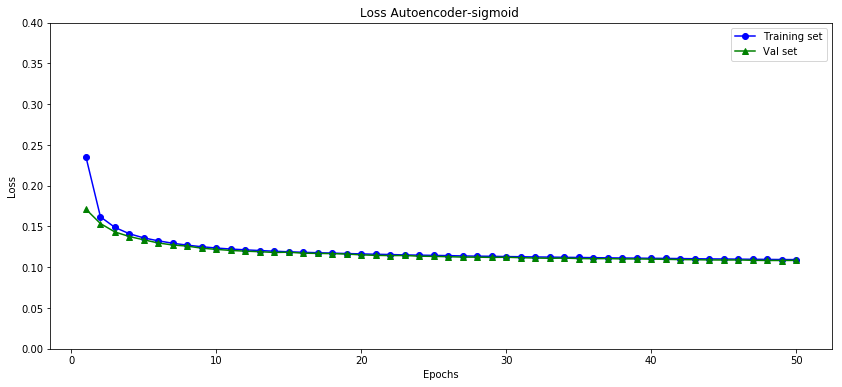

In [37]:
results2 = autoencoder.fit(x_train, x_train,callbacks = [monitor],epochs=50,batch_size=128,shuffle=True,validation_data=(x_test, x_test))
results= results2.history

loss_values1 = results['loss']
val_loss_values1 = results['val_loss']
epochs1 = range(1, len(loss_values1) + 1)
f, axarr = plt.subplots(1,figsize=(14,6))
axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
axarr.set_title('Loss Autoencoder-sigmoid ')
axarr.set_ylim(0,0.4)
axarr.set_xlabel('Epochs')
axarr.set_ylabel('Loss')
axarr.legend(loc="upper right", fancybox= True)
plt.show()

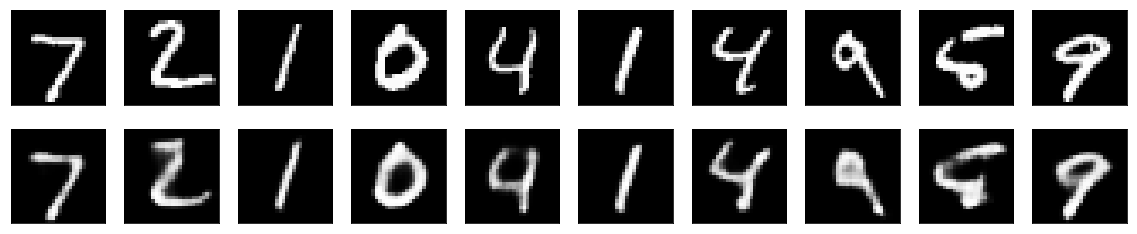

In [38]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

De los resultados obtenidos, pese a estar correctos y diferenciar cada término, no se aprecian de manera clara como los otros autoencoders creados, por ejemplo ReLU con 64 dimensiones. Por lo que aplicar capas convolucionales, no mejora el desempeño de nuestro autoencoder.

### 3.2 Denoising

a,b,c) A continuación, se cargará el dataset, y se creará una versión ruidosa de este.

In [1]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping 
from keras.models import load_model
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
import time

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]
print ('dimensiones entrada :')
print  ('x_train ', x_train.shape ,', y_train ' ,y_train.shape)
print  ('x_test ', x_test.shape ,', y_test ' ,y_test.shape)
print  ('x_val ', x_val.shape ,', y_val ' ,y_val.shape)

from numpy.random import binomial
noise_level = 0.4
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

Using TensorFlow backend.


dimensiones entrada :
x_train  (55000, 784) , y_train  (55000,)
x_test  (10000, 784) , y_test  (10000,)
x_val  (5000, 784) , y_val  (5000,)


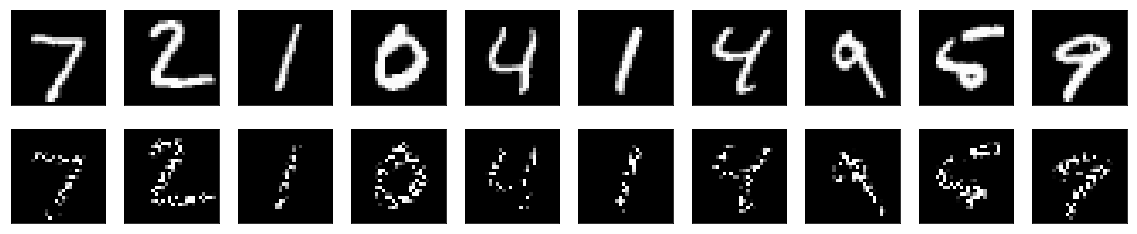

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Luego de mostrar a que tipo de ruido se enfrentará el autencoder, se procederá a entrenar modelos bajos distintos factores de ruido, desde 0.1 hasta 0.6. Se detallará una imagen post-decoder de la predicción, y al mismo tiempo se entregara su precisión mediante kNN

factor de ruido: 0.1
ejemplos de prueba antes y despues del ruido:


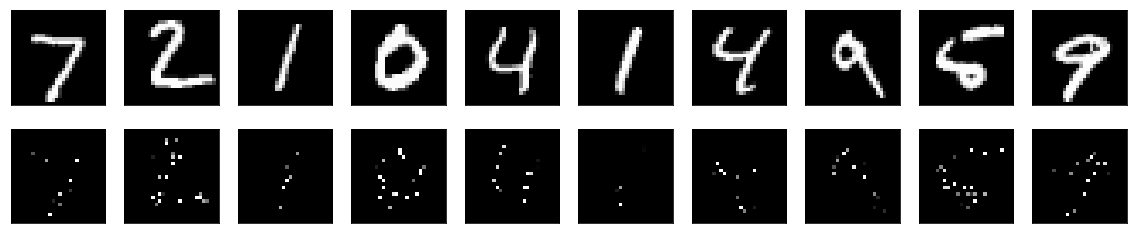

f:\python3.6\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
f:\python3.6\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Compression factor: 12.25
Epoch 00011: early stopping


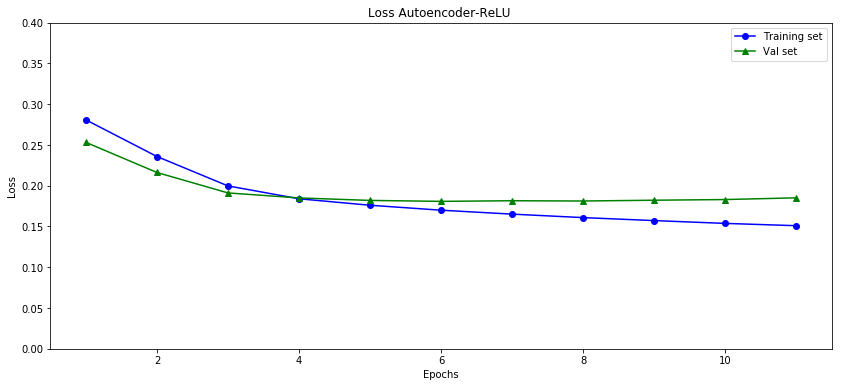

autoencoder en "x_test" sin ruido:


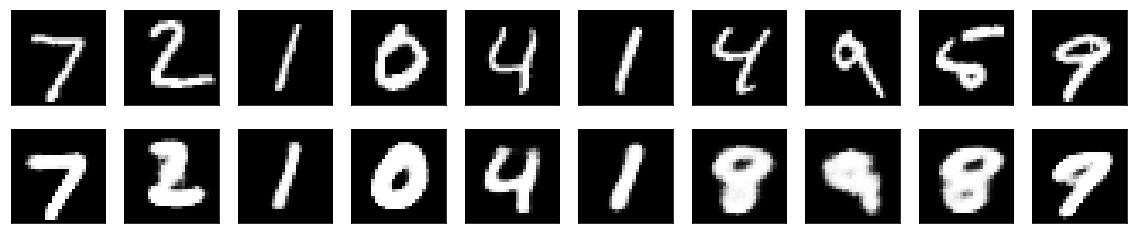

autoencoder en "noisy_x_test" con ruido:


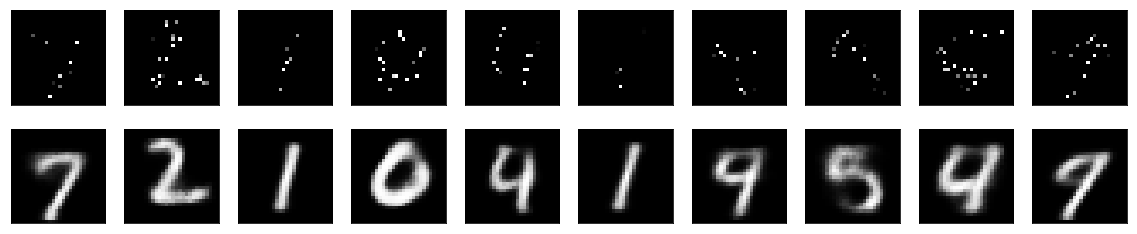

prediccion post-encoder en "noisy_x_test":


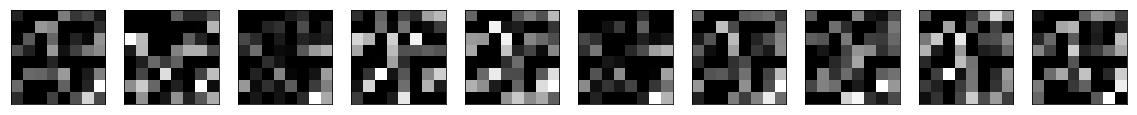

Classification Accuracy kNN 0.695 


factor de ruido: 0.2
ejemplos de prueba antes y despues del ruido:


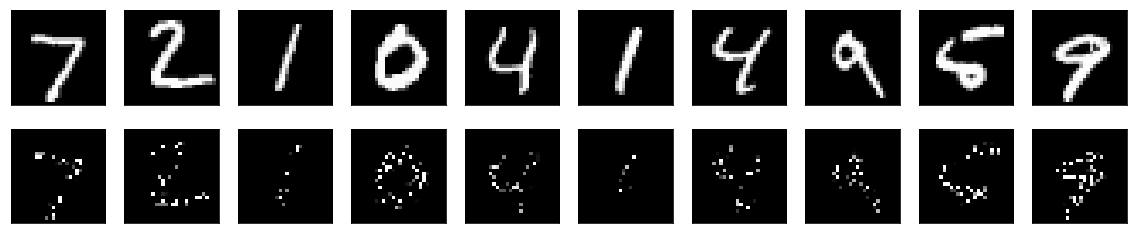

Compression factor: 12.25
Epoch 00016: early stopping


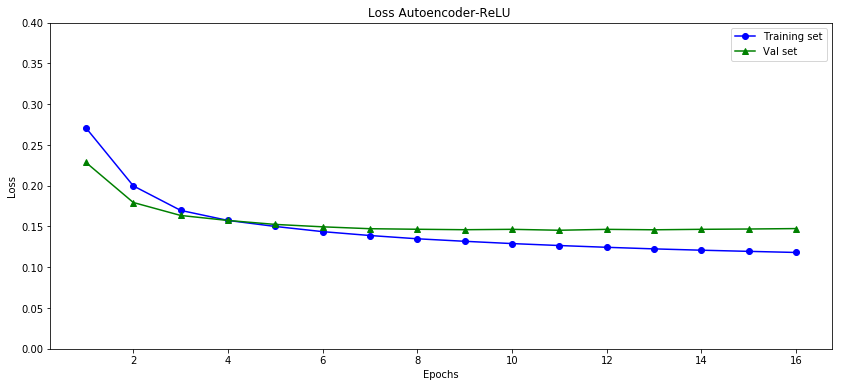

autoencoder en "x_test" sin ruido:


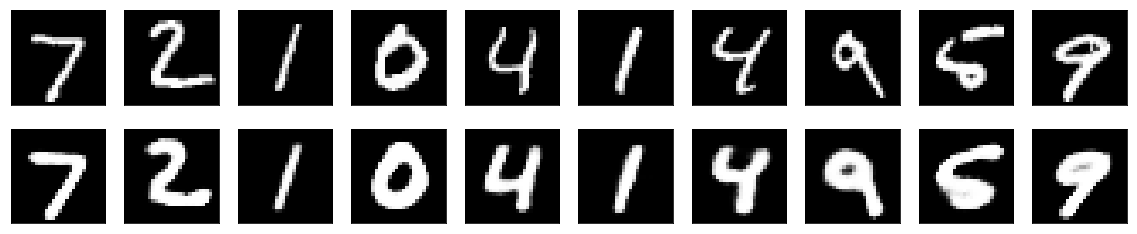

autoencoder en "noisy_x_test" con ruido:


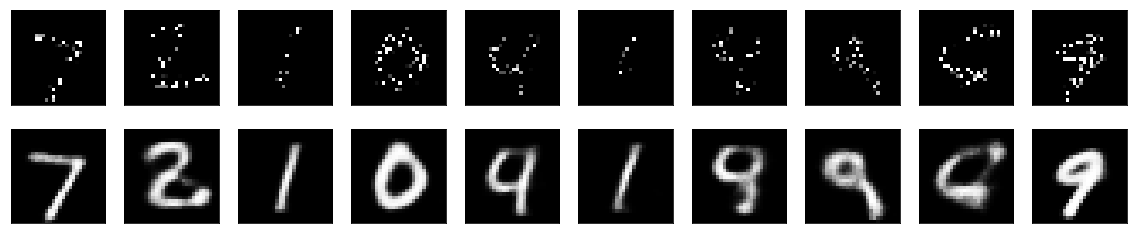

prediccion post-encoder en "noisy_x_test":


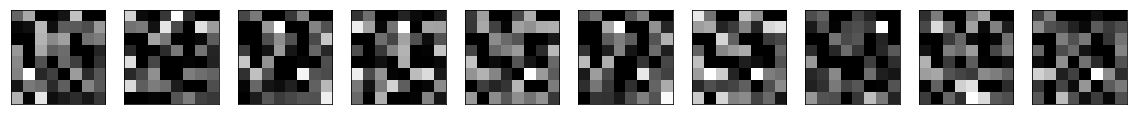

Classification Accuracy kNN 0.866 


factor de ruido: 0.3
ejemplos de prueba antes y despues del ruido:


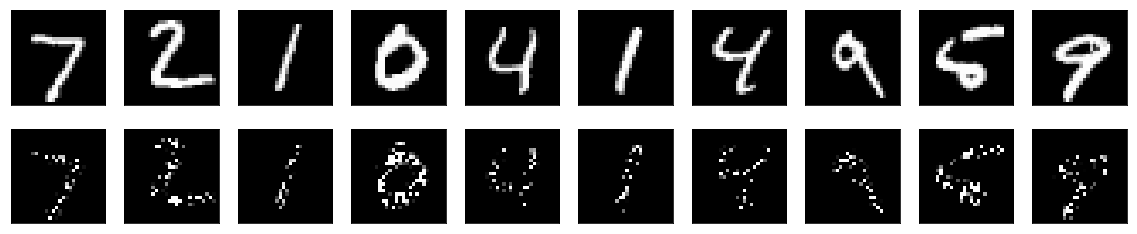

Compression factor: 12.25
Epoch 00021: early stopping


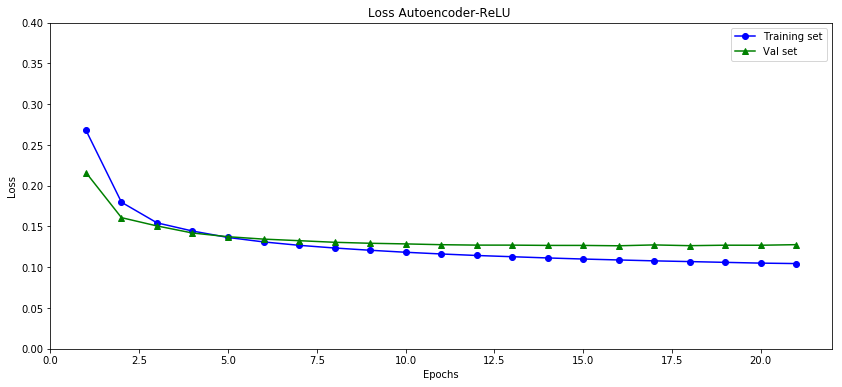

autoencoder en "x_test" sin ruido:


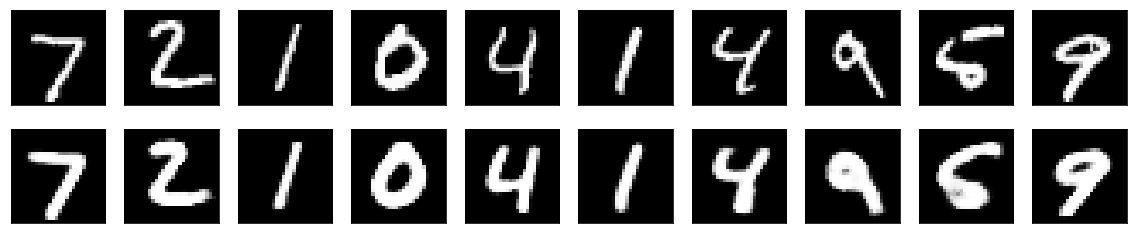

autoencoder en "noisy_x_test" con ruido:


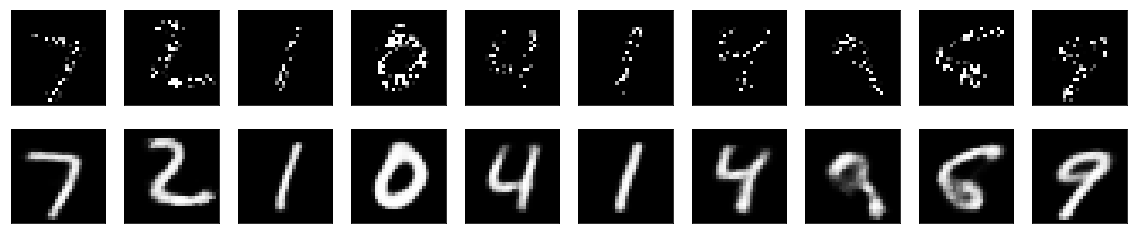

prediccion post-encoder en "noisy_x_test":


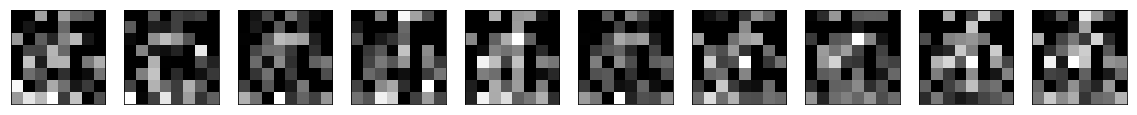

Classification Accuracy kNN 0.926 


factor de ruido: 0.4
ejemplos de prueba antes y despues del ruido:


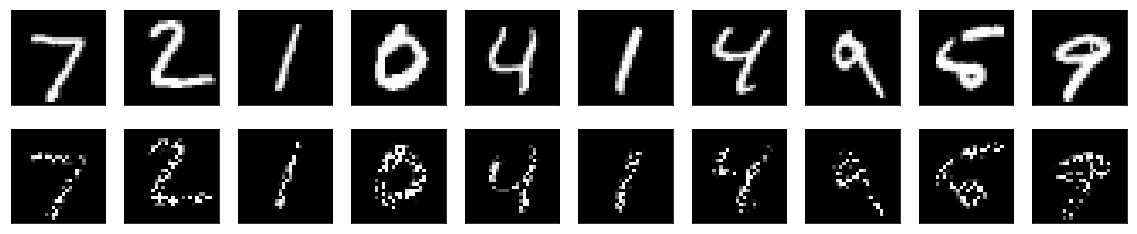

Compression factor: 12.25
Epoch 00025: early stopping


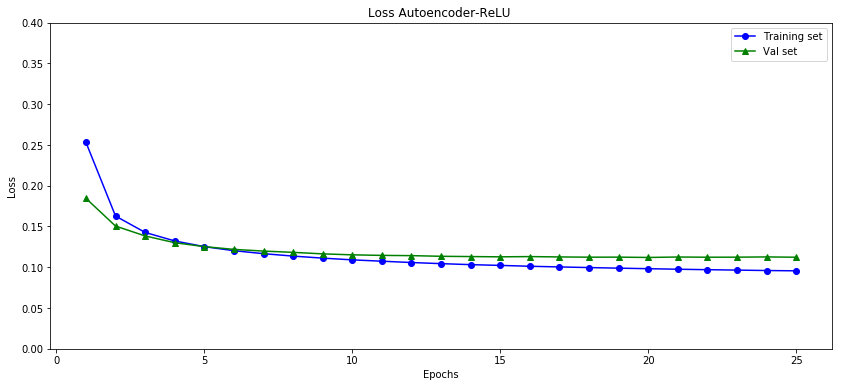

autoencoder en "x_test" sin ruido:


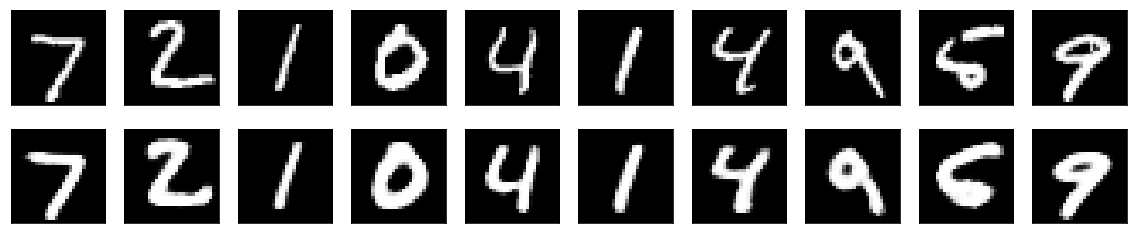

autoencoder en "noisy_x_test" con ruido:


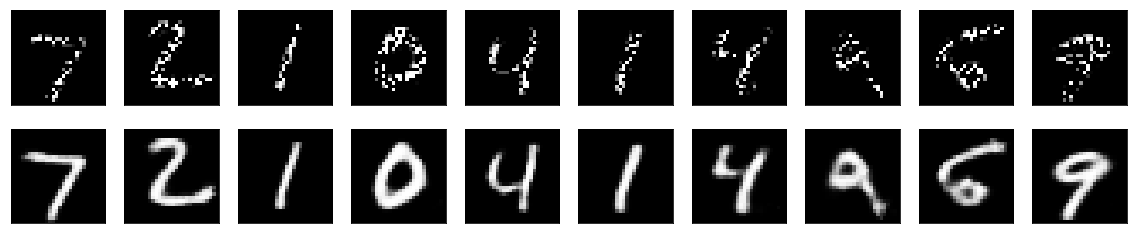

prediccion post-encoder en "noisy_x_test":


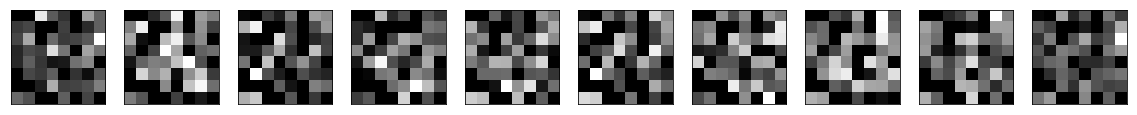

Classification Accuracy kNN 0.948 


factor de ruido: 0.5
ejemplos de prueba antes y despues del ruido:


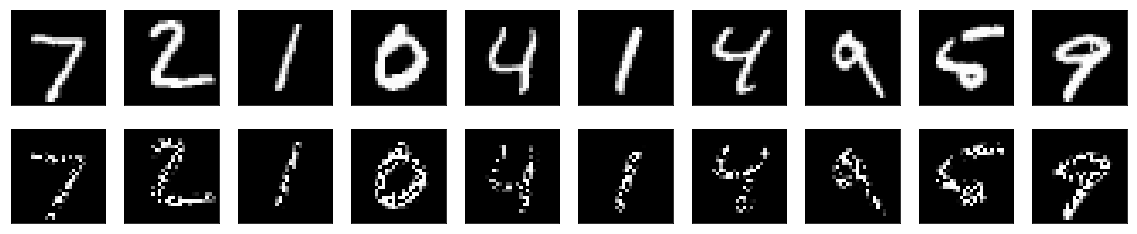

Compression factor: 12.25
Epoch 00033: early stopping


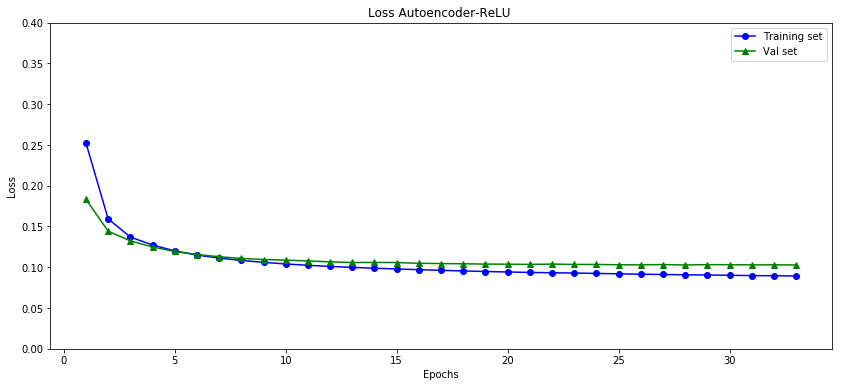

autoencoder en "x_test" sin ruido:


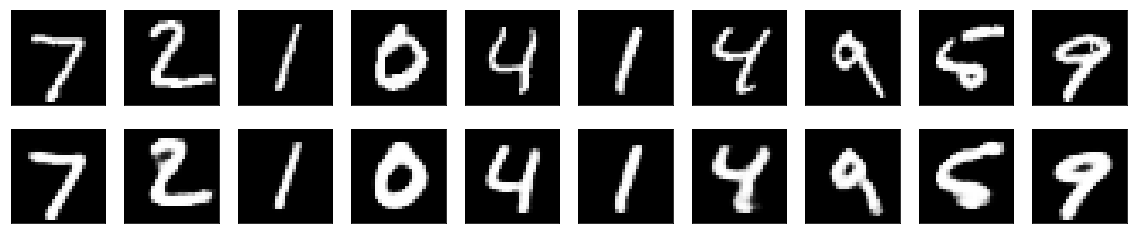

autoencoder en "noisy_x_test" con ruido:


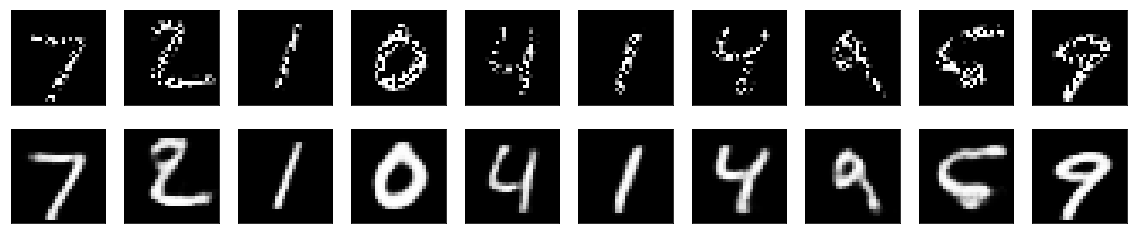

prediccion post-encoder en "noisy_x_test":


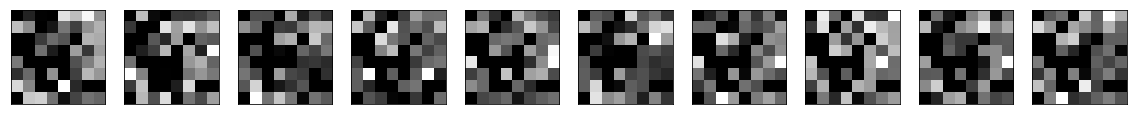

Classification Accuracy kNN 0.959 


factor de ruido: 0.6
ejemplos de prueba antes y despues del ruido:


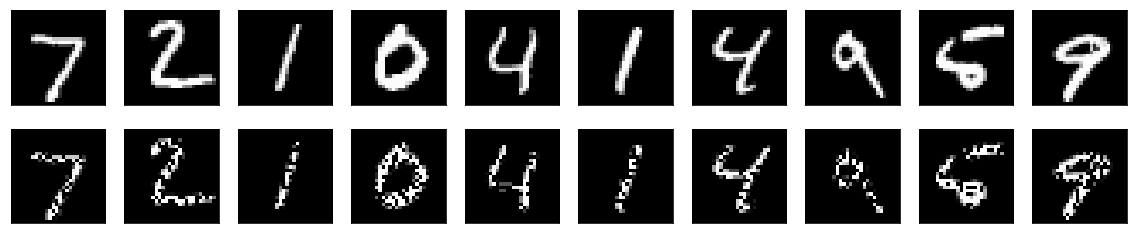

Compression factor: 12.25
Epoch 00040: early stopping


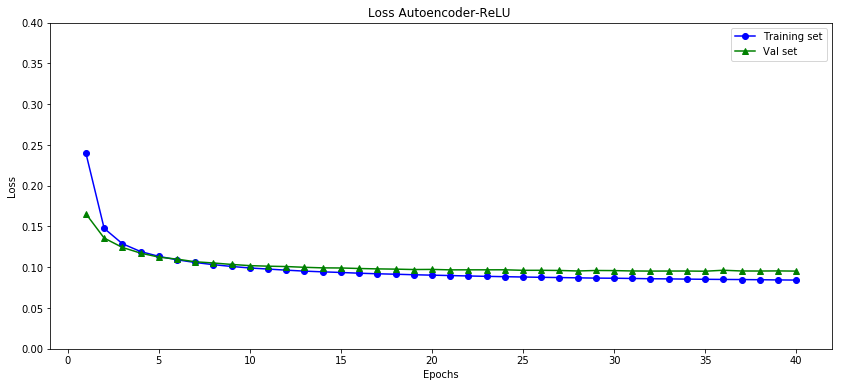

autoencoder en "x_test" sin ruido:


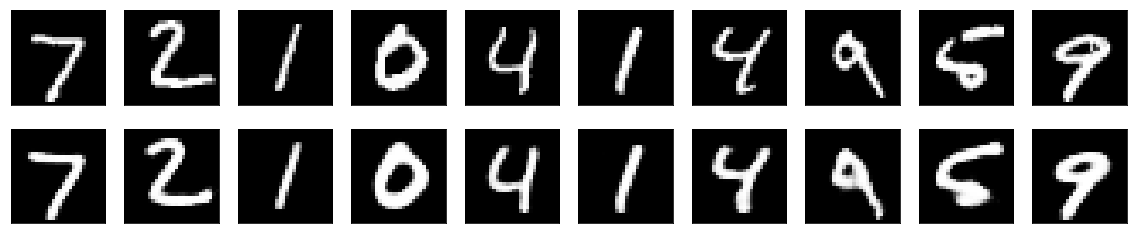

autoencoder en "noisy_x_test" con ruido:


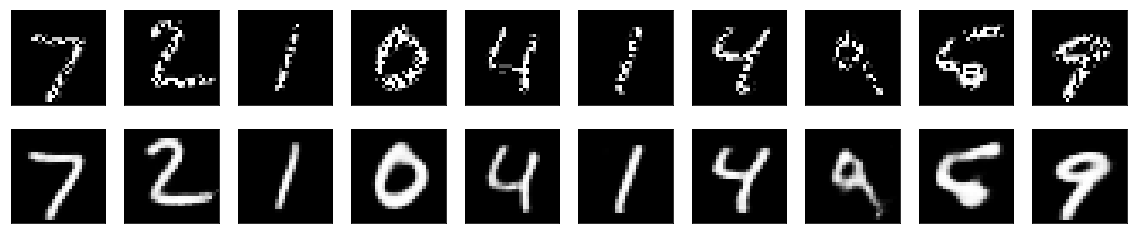

prediccion post-encoder en "noisy_x_test":


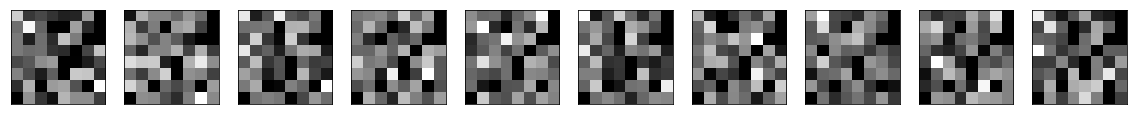

Classification Accuracy kNN 0.966 




In [15]:
noise = [0.1,0.2,0.3,0.4,0.5,0.6]
from numpy.random import binomial
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

for factor in noise:
    
    print('factor de ruido: '+str(factor))
    noise_level = factor
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    
    print('ejemplos de prueba antes y despues del ruido:')
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    input_img = Input(shape=(784,))  
    encoded1 = Dense(512, activation='relu')(input_img)
    encoded2 = Dense(256, activation='relu')(encoded1)
    encoded3 = Dense(128, activation='relu')(encoded2)
    encoded4 = Dense(64, activation='relu')(encoded3)
    decoded4 = Dense(128, activation='relu')(encoded4)
    decoded3 = Dense(256, activation='relu')(decoded4)
    decoded2 = Dense(512, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded4)


    autoencoder.compile(optimizer="adam", loss='binary_crossentropy')
    compression_factor = float(x_train.shape[1]) / 64
    print("Compression factor: %s" % compression_factor)

    results2 = autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=256,callbacks=[monitor], validation_data=(noisy_x_val, x_val),shuffle=True,verbose=0)
    results= results2.history

    loss_values1 = results['loss']
    val_loss_values1 = results['val_loss']
    epochs1 = range(1, len(loss_values1) + 1)
    f, axarr = plt.subplots(1,figsize=(14,6))
    axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
    axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
    axarr.set_title('Loss Autoencoder-ReLU ')
    axarr.set_ylim(0,0.4)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    axarr.legend(loc="upper right", fancybox= True)
    plt.show()
    
    print('autoencoder en "x_test" sin ruido:')
    
    decoded_imgs = autoencoder.predict(x_test)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print('autoencoder en "noisy_x_test" con ruido:')
    decoded_imgs = autoencoder.predict(noisy_x_test)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print('prediccion post-encoder en "noisy_x_test":')
    
    encoded_train = encoder.predict(noisy_x_train)
    encoded_test = encoder.predict(noisy_x_test)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(encoded_test[i].reshape(8, 8),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ('Classification Accuracy kNN %.3f \n\n' % clf.score(encoded_test,y_test))


De los resultados, podemos extraer que: la precisión de kNN aumenta a medida que disminuye el ruido. Los modelos presentan overfitting de forma exagerada a mayor ruido, al mismo tiempo, a mayor ruido, menos cantidad de epochs. Cuando se entregan como inputs imagenes sin ruidos, la predicción tiende a aumentar las proporciones de los valores, entregando resultados irreconocibles en algunos casos. A partir de un ruido del 70%, se comienza a obtener resultados claros y diferenciables entre si.

d) Finalmente se realizará lo ejecutado anteriormente, pero esta vez se cambiará el tipo de ruido.

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]
print ('dimensiones entrada :')
print  ('x_train ', x_train.shape ,', y_train ' ,y_train.shape)
print  ('x_test ', x_test.shape ,', y_test ' ,y_test.shape)
print  ('x_val ', x_val.shape ,', y_val ' ,y_val.shape)

from numpy.random import binomial
noise_factor = 0.5
noise_mask = binomial(n=1,p=noise_factor,size=x_train.shape)
noisy_x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
noise_mask = binomial(n=1,p=noise_factor,size=x_val.shape)
noisy_x_val = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
noise_mask = binomial(n=1,p=noise_factor,size=x_test.shape)
noisy_x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


noisy_x_train = np.clip(noisy_x_train, 0., 1.)
noisy_x_test = np.clip(noisy_x_test, 0., 1.)
noisy_x_val = np.clip(noisy_x_val, 0., 1.)

dimensiones entrada :
x_train  (55000, 784) , y_train  (55000,)
x_test  (10000, 784) , y_test  (10000,)
x_val  (5000, 784) , y_val  (5000,)


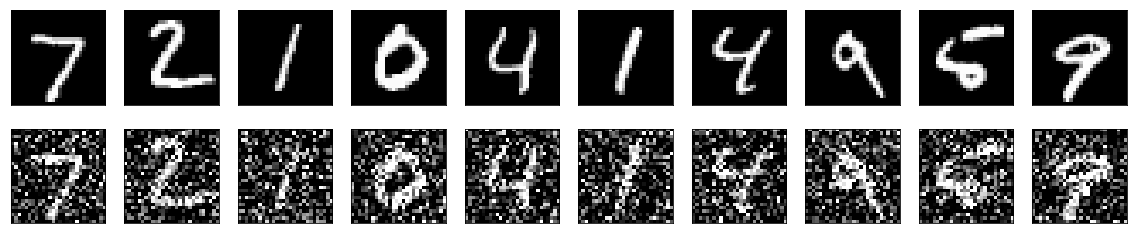

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

factor de ruido: 0.9
ejemplos de prueba antes y despues del ruido:


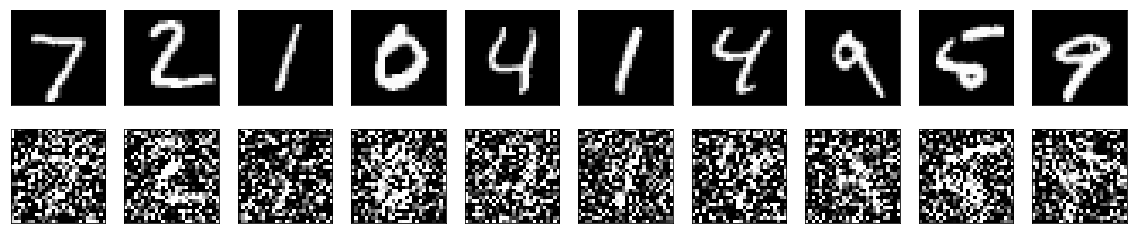

f:\python3.6\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
f:\python3.6\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Compression factor: 12.25
Epoch 00017: early stopping


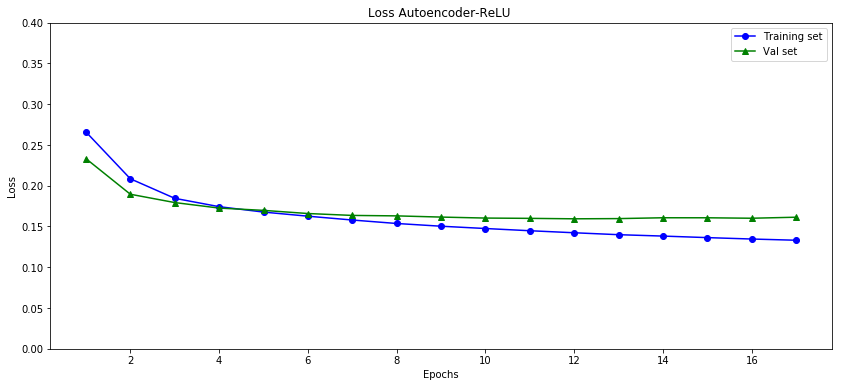

autoencoder en "x_test" sin ruido:


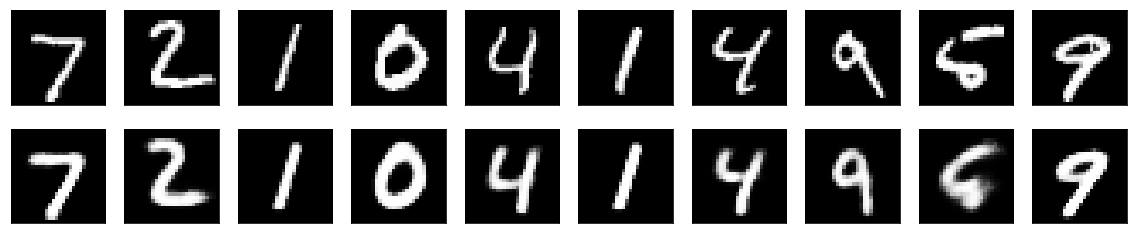

autoencoder en "noisy_x_test" con ruido:


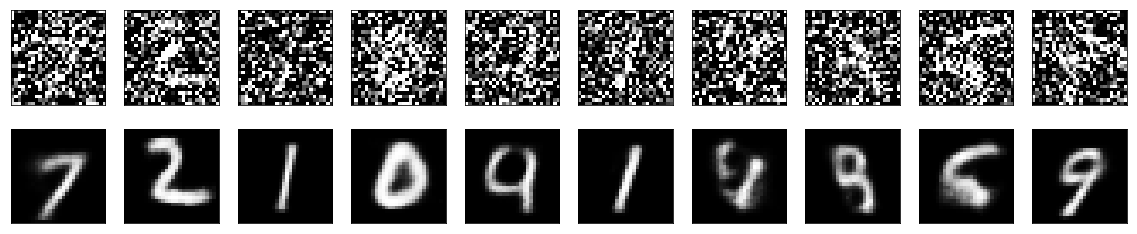

prediccion post-encoder en "noisy_x_test":


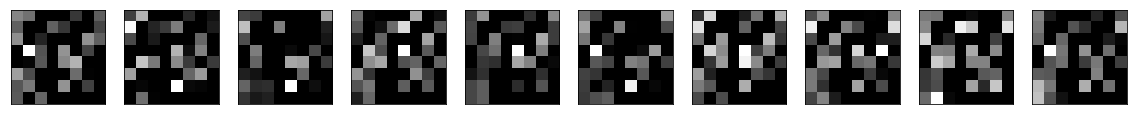

Classification Accuracy kNN 0.793 


factor de ruido: 0.8
ejemplos de prueba antes y despues del ruido:


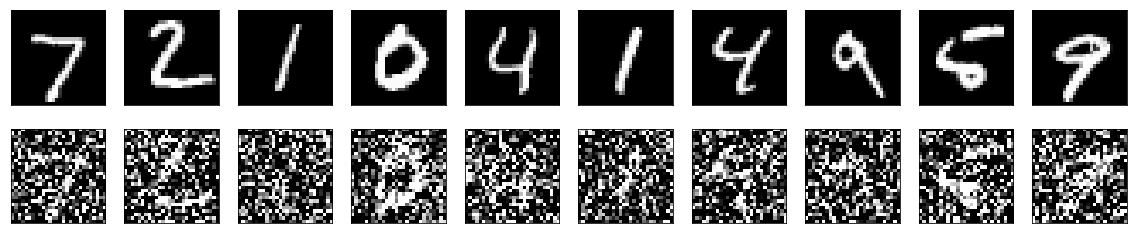

Compression factor: 12.25
Epoch 00020: early stopping


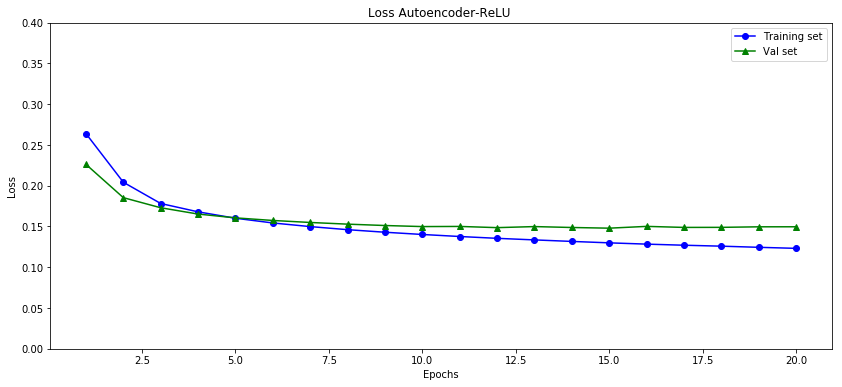

autoencoder en "x_test" sin ruido:


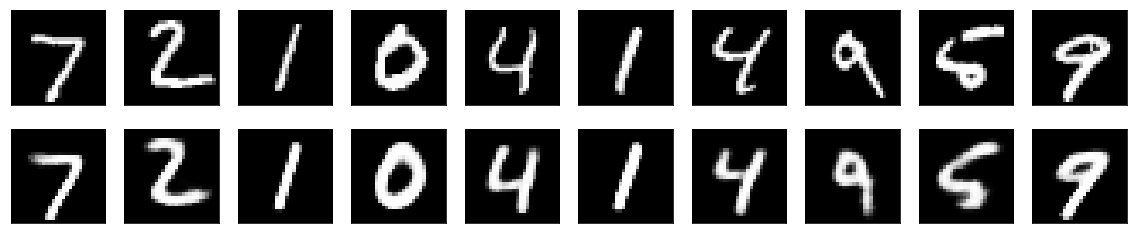

autoencoder en "noisy_x_test" con ruido:


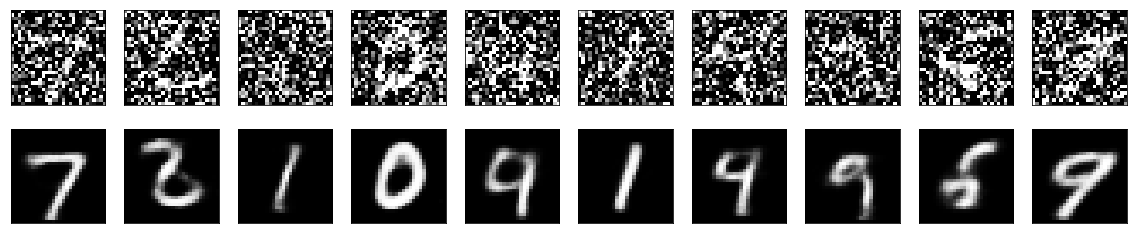

prediccion post-encoder en "noisy_x_test":


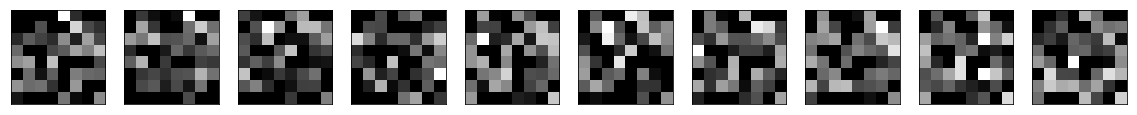

Classification Accuracy kNN 0.835 


factor de ruido: 0.7
ejemplos de prueba antes y despues del ruido:


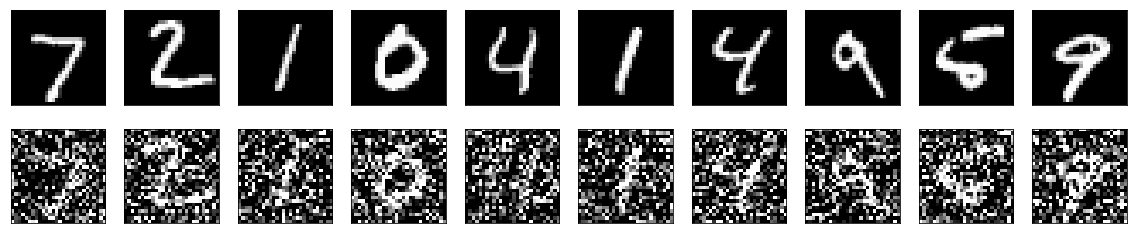

Compression factor: 12.25
Epoch 00023: early stopping


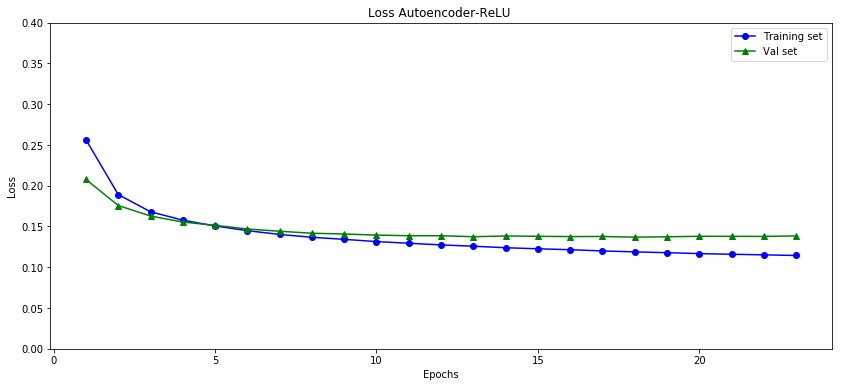

autoencoder en "x_test" sin ruido:


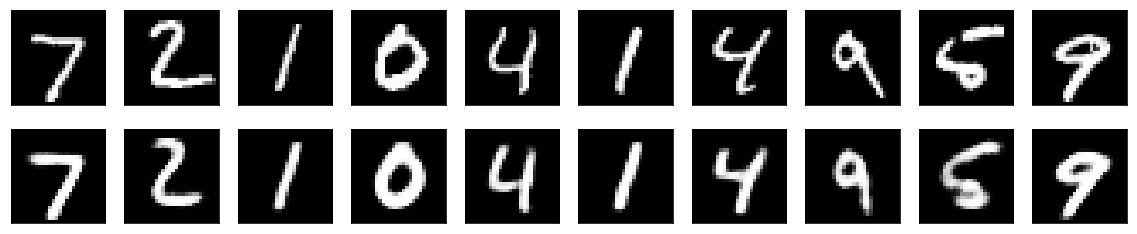

autoencoder en "noisy_x_test" con ruido:


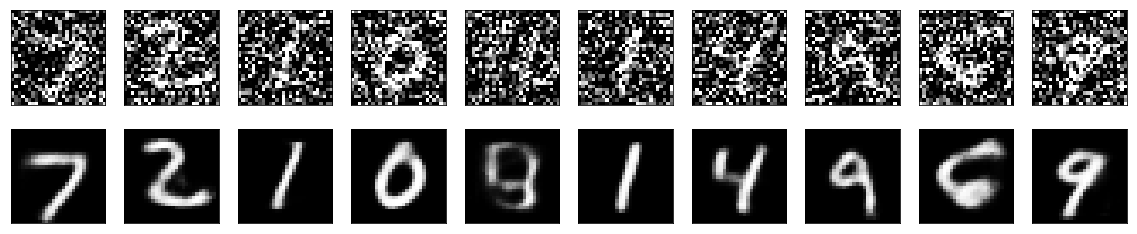

prediccion post-encoder en "noisy_x_test":


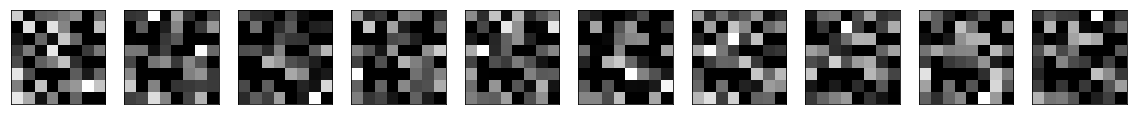

Classification Accuracy kNN 0.880 


factor de ruido: 0.6
ejemplos de prueba antes y despues del ruido:


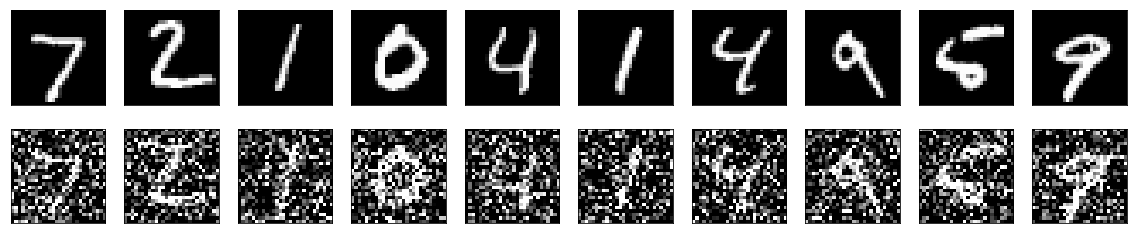

Compression factor: 12.25
Epoch 00026: early stopping


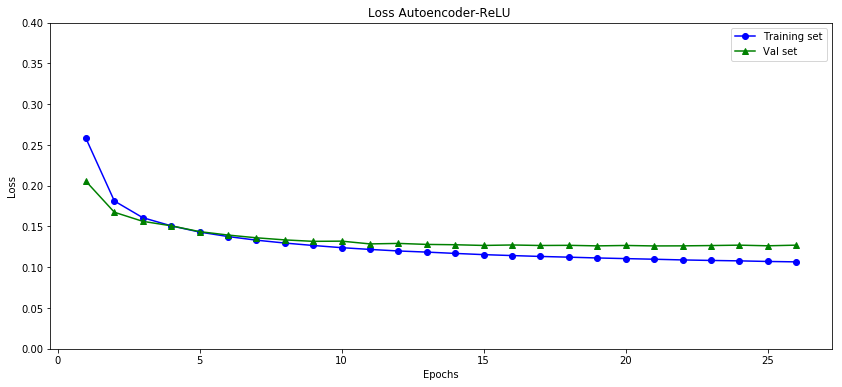

autoencoder en "x_test" sin ruido:


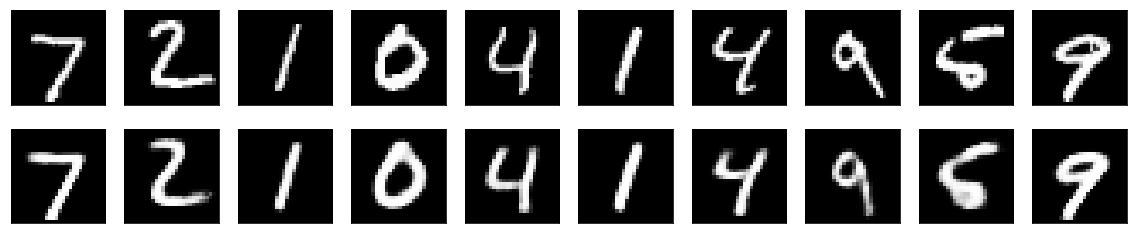

autoencoder en "noisy_x_test" con ruido:


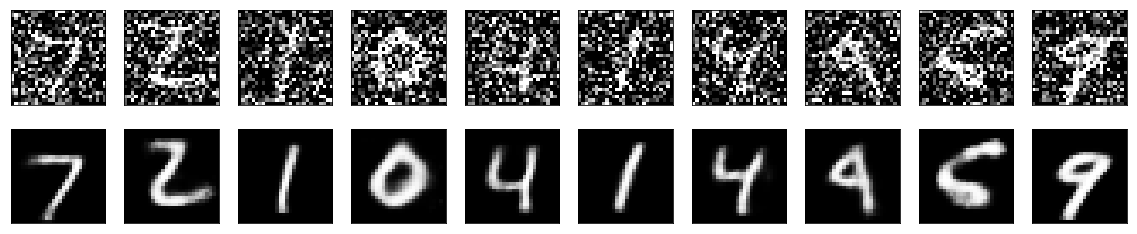

prediccion post-encoder en "noisy_x_test":


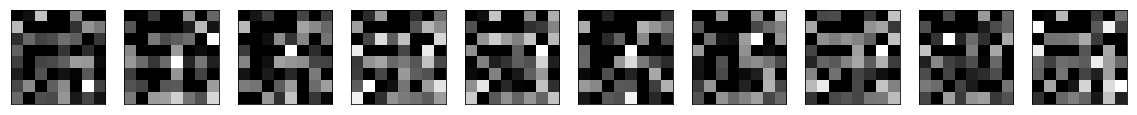

Classification Accuracy kNN 0.917 


factor de ruido: 0.5
ejemplos de prueba antes y despues del ruido:


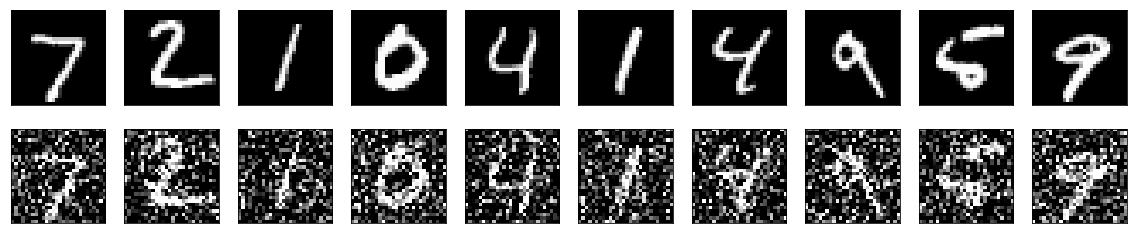

Compression factor: 12.25
Epoch 00030: early stopping


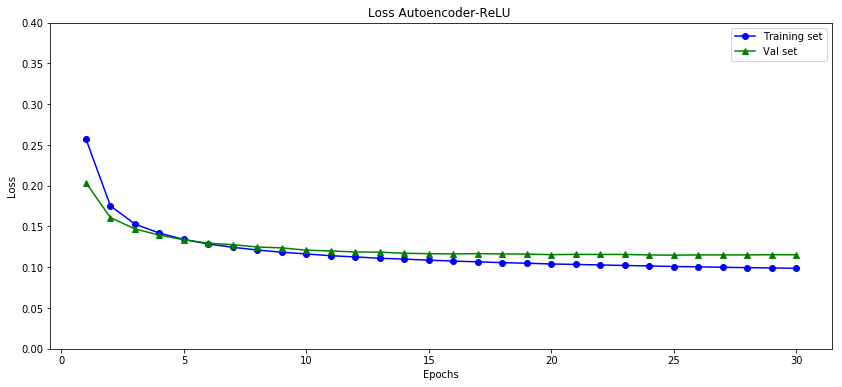

autoencoder en "x_test" sin ruido:


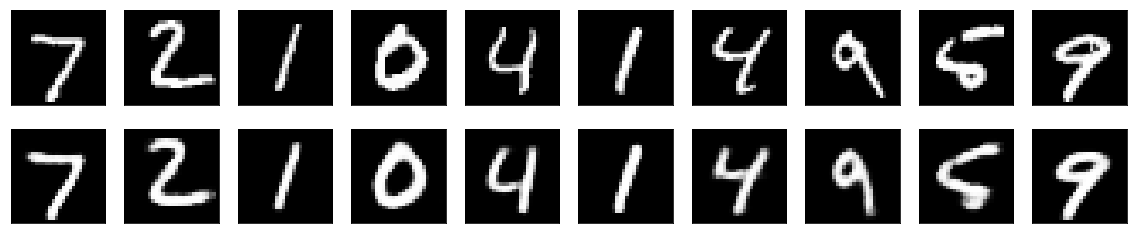

autoencoder en "noisy_x_test" con ruido:


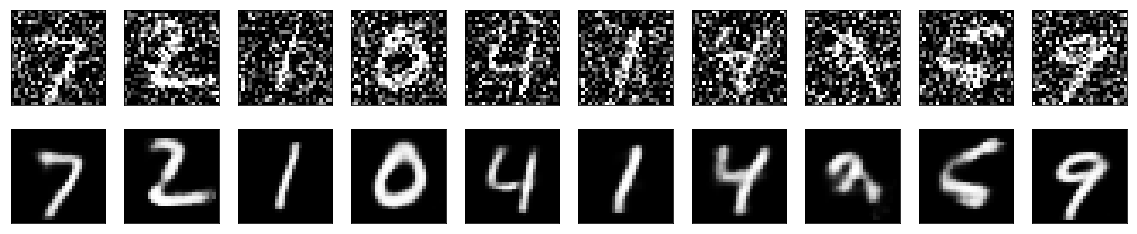

prediccion post-encoder en "noisy_x_test":


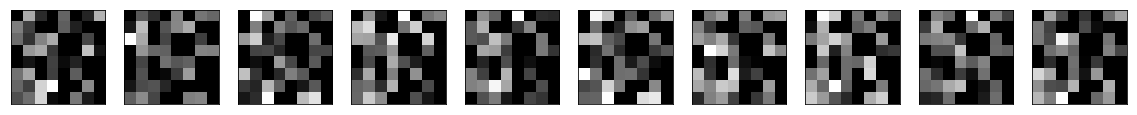

Classification Accuracy kNN 0.937 


factor de ruido: 0.4
ejemplos de prueba antes y despues del ruido:


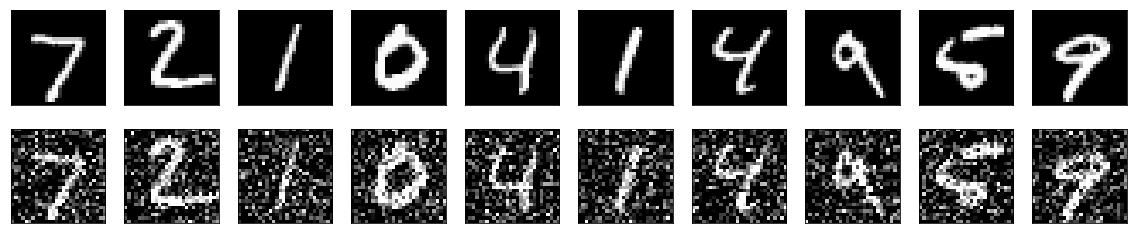

Compression factor: 12.25
Epoch 00037: early stopping


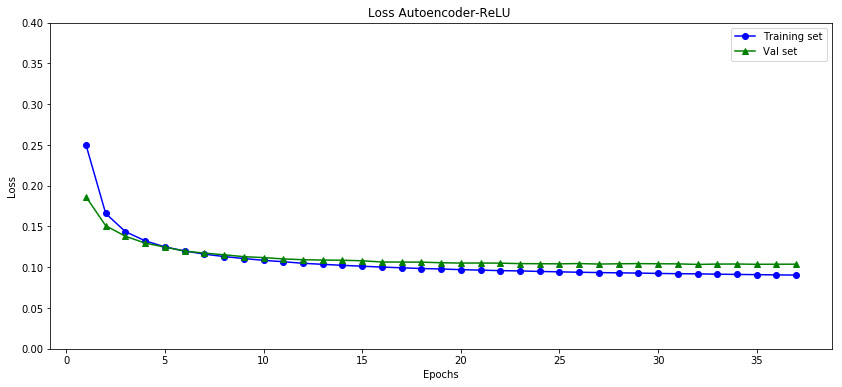

autoencoder en "x_test" sin ruido:


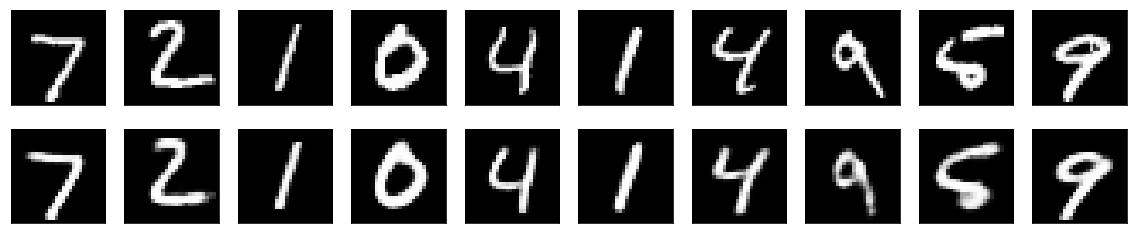

autoencoder en "noisy_x_test" con ruido:


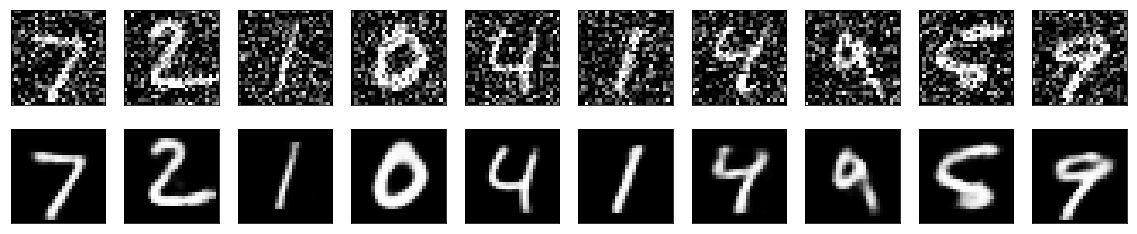

prediccion post-encoder en "noisy_x_test":


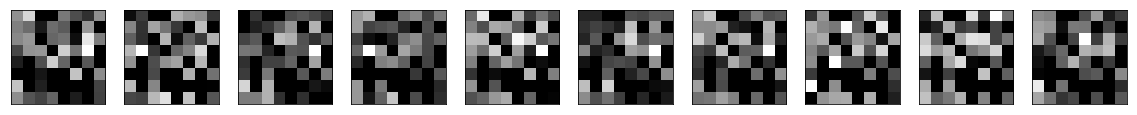

Classification Accuracy kNN 0.956 


factor de ruido: 0.3
ejemplos de prueba antes y despues del ruido:


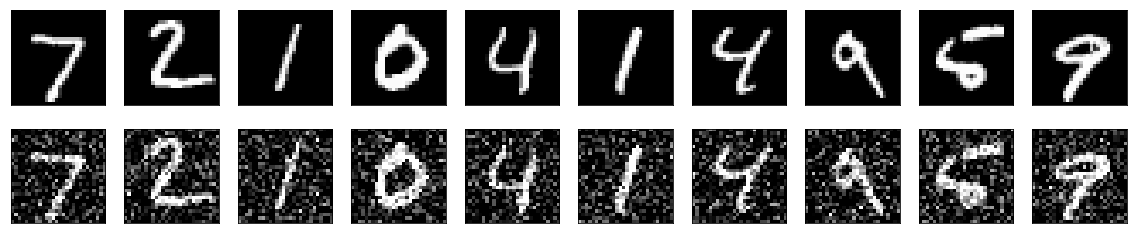

Compression factor: 12.25


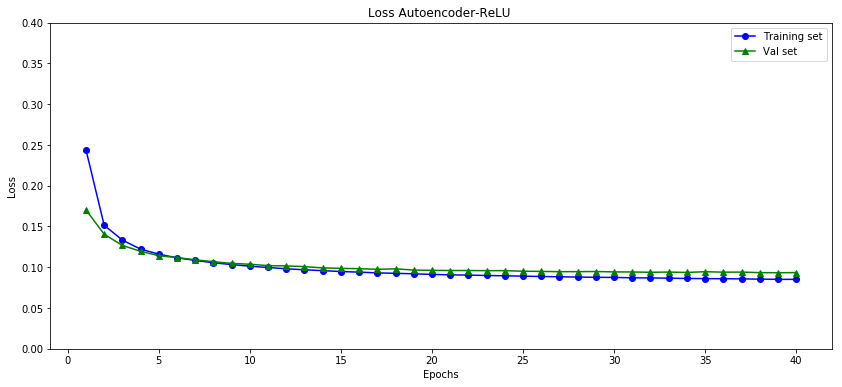

autoencoder en "x_test" sin ruido:


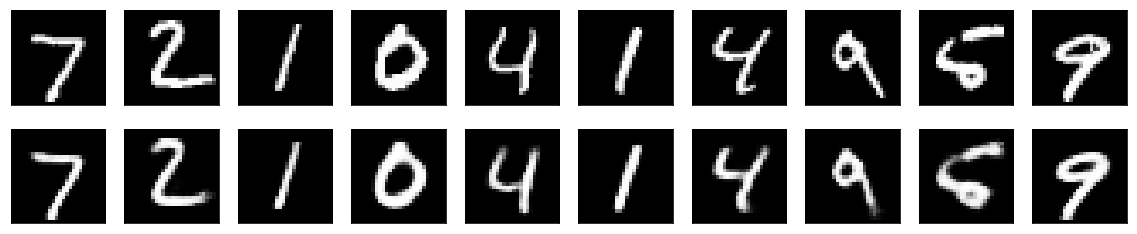

autoencoder en "noisy_x_test" con ruido:


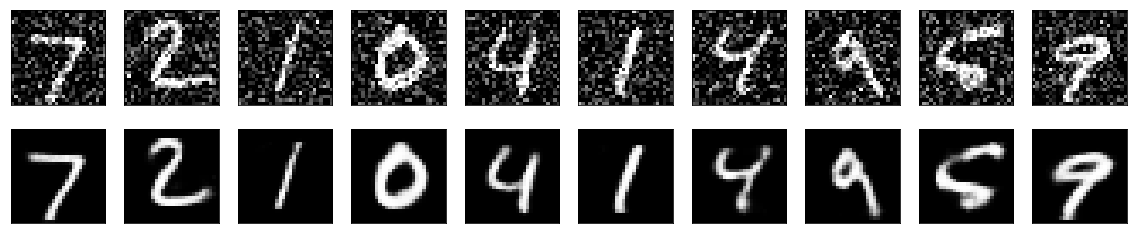

prediccion post-encoder en "noisy_x_test":


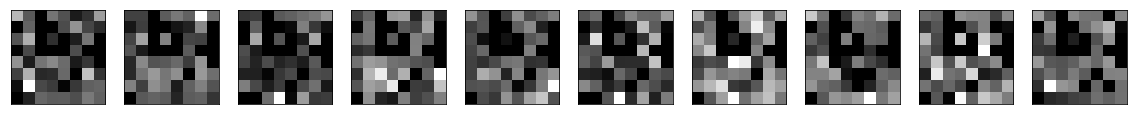

Classification Accuracy kNN 0.965 




In [6]:
noise = [0.9,0.8,0.7,0.6,0.5,0.4,0.3]
from numpy.random import binomial
monitor = EarlyStopping(monitor = 'val_loss',min_delta=1e-6,patience=5,verbose=1,mode='auto')

for factor in noise:
    
    print('factor de ruido: '+str(factor))
    noise_factor = factor
    noise_mask = binomial(n=1,p=noise_factor,size=x_train.shape)
    noisy_x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    noise_mask = binomial(n=1,p=noise_factor,size=x_val.shape)
    noisy_x_val = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
    noise_mask = binomial(n=1,p=noise_factor,size=x_test.shape)
    noisy_x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


    noisy_x_train = np.clip(noisy_x_train, 0., 1.)
    noisy_x_test = np.clip(noisy_x_test, 0., 1.)
    noisy_x_val = np.clip(noisy_x_val, 0., 1.)

    
    print('ejemplos de prueba antes y despues del ruido:')
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    input_img = Input(shape=(784,))  
    encoded1 = Dense(512, activation='relu')(input_img)
    encoded2 = Dense(256, activation='relu')(encoded1)
    encoded3 = Dense(128, activation='relu')(encoded2)
    encoded4 = Dense(64, activation='relu')(encoded3)
    decoded4 = Dense(128, activation='relu')(encoded4)
    decoded3 = Dense(256, activation='relu')(decoded4)
    decoded2 = Dense(512, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded4)


    autoencoder.compile(optimizer="adam", loss='binary_crossentropy')
    compression_factor = float(x_train.shape[1]) / 64
    print("Compression factor: %s" % compression_factor)

    results2 = autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=256,callbacks=[monitor], validation_data=(noisy_x_val, x_val),shuffle=True,verbose=0)
    results= results2.history

    loss_values1 = results['loss']
    val_loss_values1 = results['val_loss']
    epochs1 = range(1, len(loss_values1) + 1)
    f, axarr = plt.subplots(1,figsize=(14,6))
    axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
    axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
    axarr.set_title('Loss Autoencoder-ReLU ')
    axarr.set_ylim(0,0.4)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    axarr.legend(loc="upper right", fancybox= True)
    plt.show()
    
    print('autoencoder en "x_test" sin ruido:')
    
    decoded_imgs = autoencoder.predict(x_test)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print('autoencoder en "noisy_x_test" con ruido:')
    decoded_imgs = autoencoder.predict(noisy_x_test)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print('prediccion post-encoder en "noisy_x_test":')
    
    encoded_train = encoder.predict(noisy_x_train)
    encoded_test = encoder.predict(noisy_x_test)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(encoded_test[i].reshape(8, 8),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ('Classification Accuracy kNN %.3f \n\n' % clf.score(encoded_test,y_test))

Si bien el comportamiento que tuvo esta prueba fue similar a la anterior en casi todos los aspectos. Existe una particularidad al momento de predecir los datos sin ruidos, los cuales no se ven comprometidos de gran manera como los resultados del experimento anterior. Dado esto, podriamos decir que para crear un modelo mas robusto, cuyas predicciones sean mas versatiles y tolerante a fallas y ruidos, se podria aplicar este tipo de ruido en los datos de entrenamiento.